In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

#Setting a nice plotting style
sns.set(style="whitegrid")

## Data extraction

In [4]:
training_data = np.load('/kaggle/input/time-series-training-dataset/training_data.npy')
valid_periods = np.load('/kaggle/input/time-series-training-dataset/valid_periods.npy')
categories = np.load('/kaggle/input/time-series-training-dataset/categories.npy')

def remove_padding(series, valid_period):
    start, end = valid_period
    return series[start:end]

trimmed_data = [remove_padding(training_data[i], valid_periods[i]) for i in range(len(training_data))]
print(len(trimmed_data))

48000


## Visualization of some temporal series


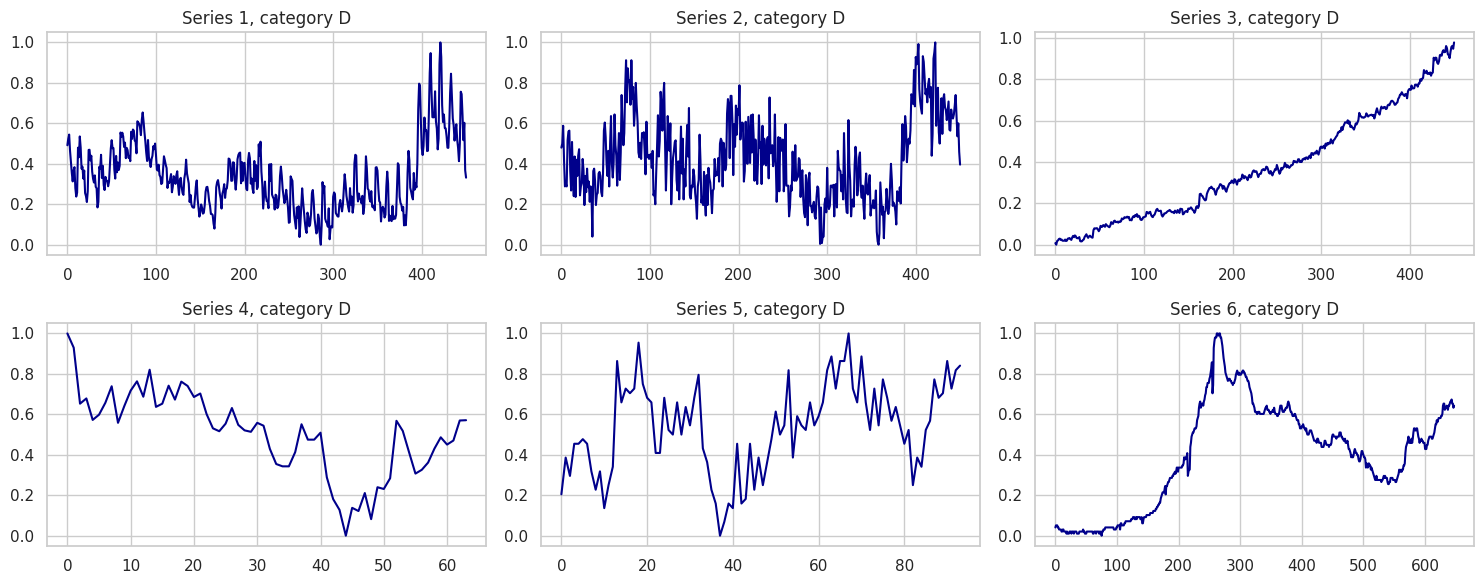

In [20]:
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(trimmed_data[i],color='darkblue')
    plt.title(f'Series {i+1}, category {categories[i]}')
plt.tight_layout()
plt.show()

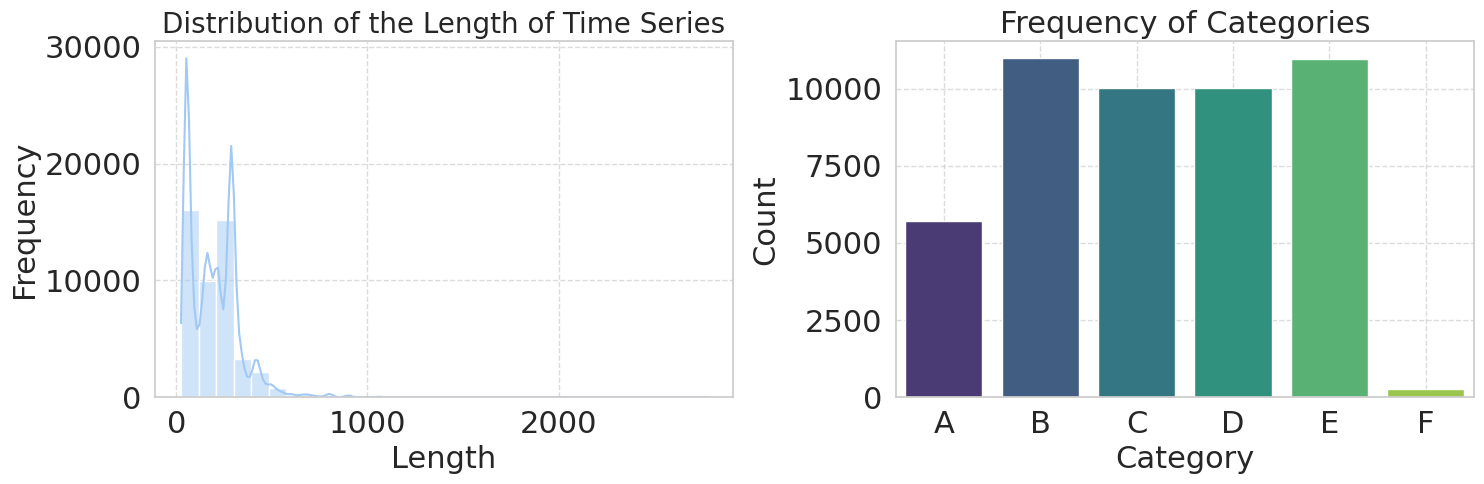

In [83]:
# Set a seaborn style for improved aesthetics
sns.set(style="whitegrid", palette="pastel")

# Assuming 'trimmed_data' and 'categories' are defined somewhere in your code

lengths = [len(series) for series in trimmed_data]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot - Distribution of time series length
sns.histplot(lengths, bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of the Length of Time Series', fontsize=20)
axs[0].set_xlabel('Length', fontsize=22)
axs[0].set_ylabel('Frequency', fontsize=22)

# Increase font size for tick labels and set a grid on the first subplot
axs[0].tick_params(axis='both', labelsize=22)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Second subplot - Distribution of Categories
category_counts = np.unique(categories, return_counts=True)
sns.barplot(x=category_counts[0], y=category_counts[1], ax=axs[1], palette="viridis")
axs[1].set_title('Frequency of Categories', fontsize=22)
axs[1].set_xlabel('Category', fontsize=22)
axs[1].set_ylabel('Count', fontsize=22)

# Increase font size for tick labels and set a grid on the second subplot
axs[1].tick_params(axis='both', labelsize=22)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('distribution_and_division_by_categories_palette_viridis.pdf')
plt.savefig('distribution_and_division_by_categories_palette_viridis.jpeg')

# Show the combined plot
plt.show()

### Left: we notice there are a few very long time series

### Right: We note that there is a severe problem of class imbalance, with class F being severely under-represented. Therefore, we might take this into account in the model development

[  121   210  2569  2572  2574  6863 17087 17131 17136 17141 17142 17143
 26709 27947 32890 35537 36040 36043 36051 36072 36086 36088 37008 37247
 43789]
25


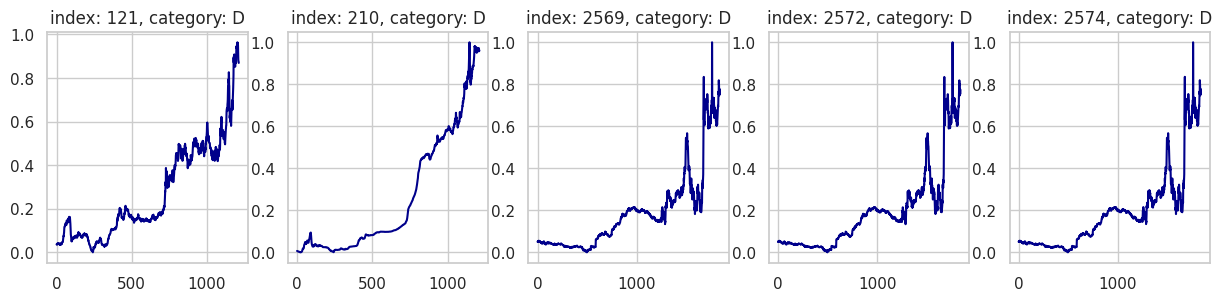

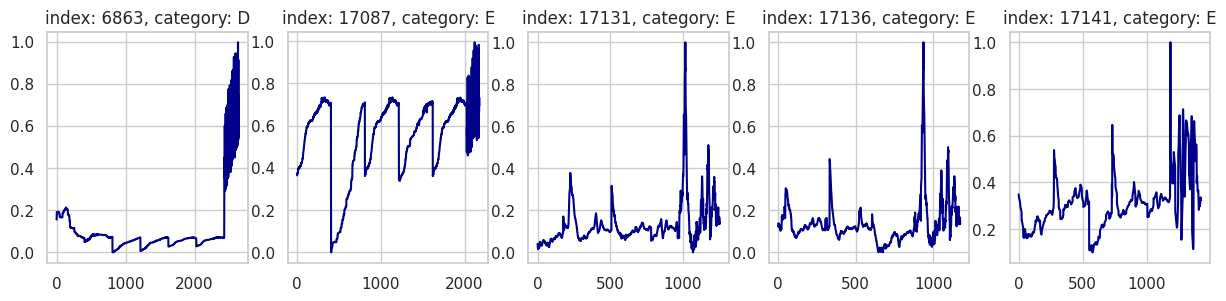

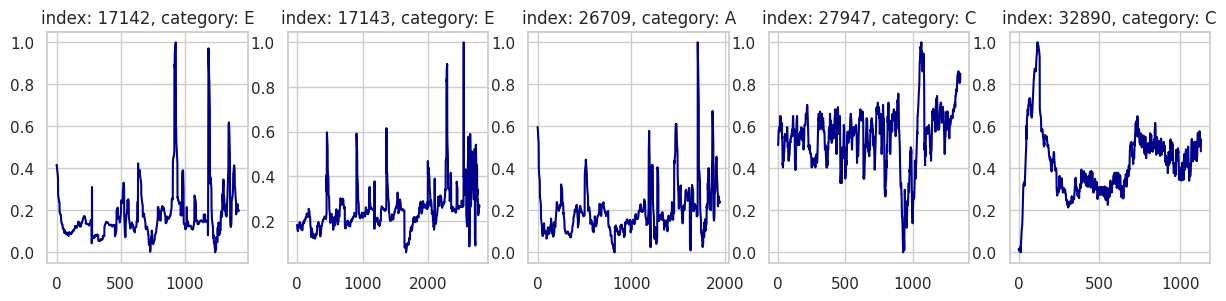

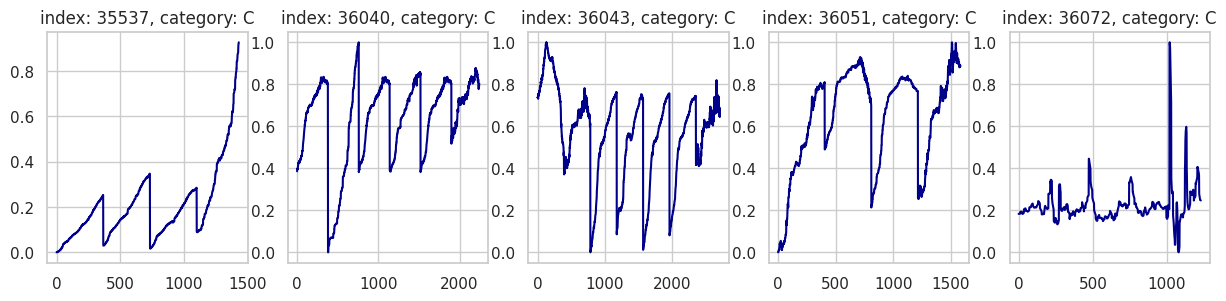

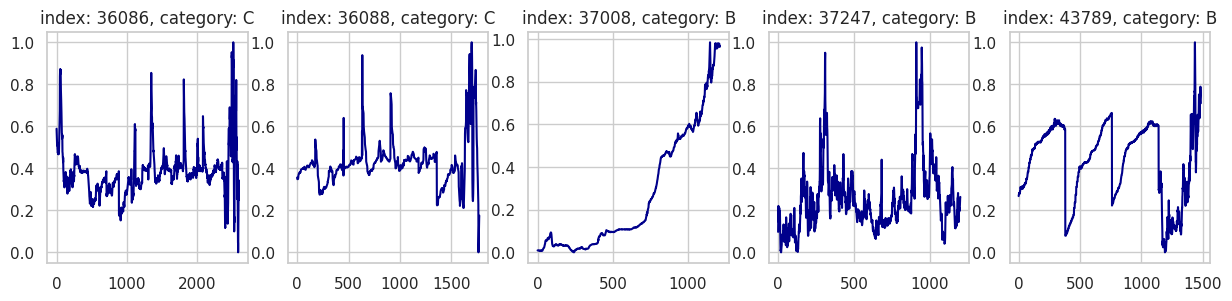

In [14]:
lengths = [len(series) for series in trimmed_data]

#We plot some of the longer time series
long_ts_indexes=np.where(np.array(lengths)>1100)[0]
print(long_ts_indexes)
print(len(long_ts_indexes))


for i in range(5):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for j in range(5):  
        tempindex=long_ts_indexes[i*5+j]
        axs[j].plot(trimmed_data[tempindex], color='darkblue')  # Set a darker blue color
        axs[j].set_title(f'index: {tempindex}, category: {categories[tempindex]}')

### There seem to be some irregular patterns in some data. # Even if not all these data can be considered real outliers, we still will exclude them from some of our analyses (accepting the risk to lose some data) to assess any potential performance improvement
   

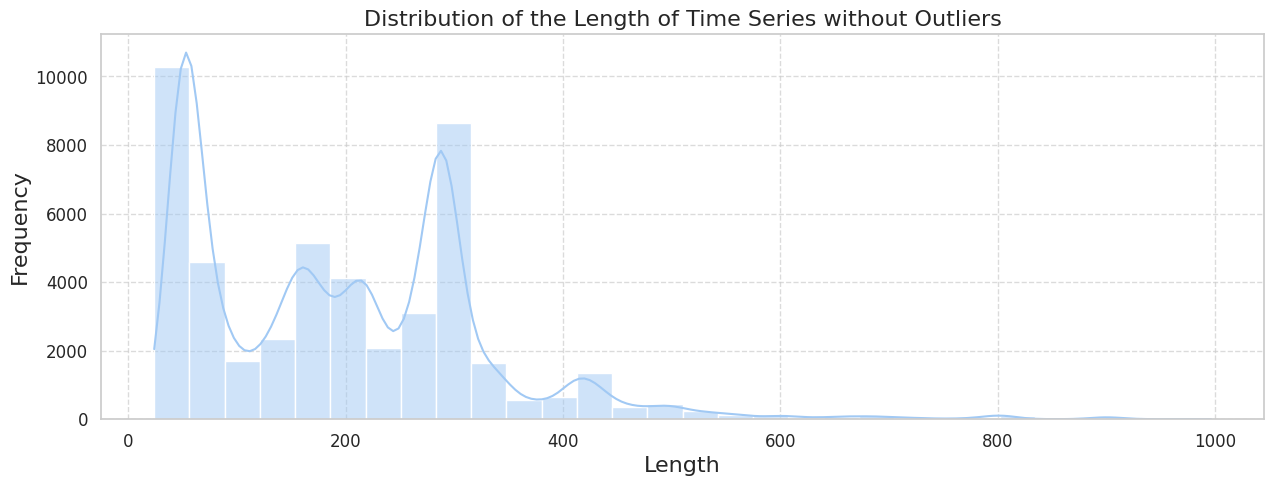

In [15]:
# Set a seaborn style for improved aesthetics
sns.set(style="whitegrid", palette="pastel")

# Distribution of time series length without outliers (no division by class)
indexes = long_ts_indexes
trimmed_data_noout = [trimmed_data[i] for i in range(len(trimmed_data)) if i not in indexes]
categories_noout = [categories[i] for i in range(len(categories)) if i not in indexes]

lengths_noout = [len(series) for series in trimmed_data_noout]

# Creating a plot
plt.figure(figsize=(15, 5))
sns.histplot(lengths_noout, bins=30, kde=True)
plt.title('Distribution of the Length of Time Series without Outliers', fontsize=16)
plt.xlabel('Length', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

# Increase font size for tick labels and set a grid
plt.tick_params(axis='both', labelsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


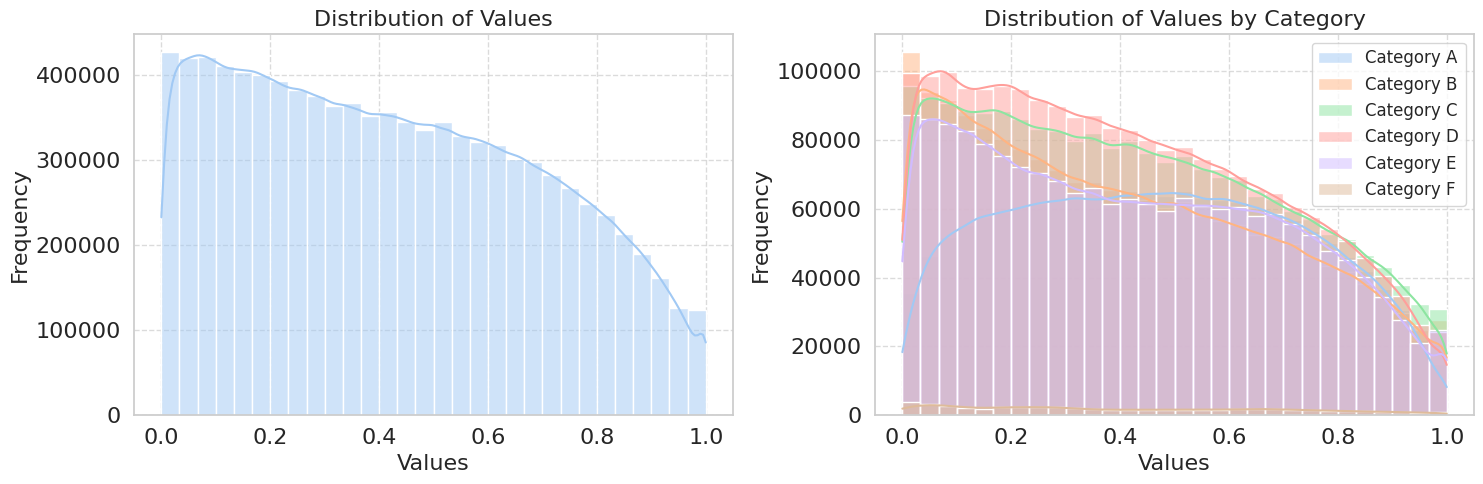

In [60]:
# Set a seaborn style for improved aesthetics
sns.set(style="whitegrid", palette="pastel")

# Create a DataFrame
dataset = pd.DataFrame({
    'values': [val for series in trimmed_data for val in series],
    'categories': [cat for series, cat in zip(trimmed_data, categories) for _ in series]
})

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot - Distribution of values
sns.histplot(dataset['values'], bins=30, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Values', fontsize=16)
axs[0].set_xlabel('Values', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=16)

# Increase font size for tick labels and set a grid on the first subplot
axs[0].tick_params(axis='both', labelsize=16)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Second subplot - Average Distribution of Values by Category
average_distributions = {}
for category in np.unique(dataset['categories']):
    category_data = dataset[dataset['categories'] == category]['values']
    sns.histplot(category_data, bins=30, kde=True, label=f'Category {category}', ax=axs[1], alpha=0.5)
    
    # Store the distribution for each category
    average_distributions[category] = np.histogram(category_data, bins=30, density=True)[0]

axs[1].set_title('Distribution of Values by Category', fontsize=16)
axs[1].set_xlabel('Values', fontsize=16)
axs[1].set_ylabel('Frequency', fontsize=16)
axs[1].legend(fontsize=12)

# Increase font size for tick labels and set a grid on the second subplot
axs[1].tick_params(axis='both', labelsize=16)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

# Now 'average_distributions' contains the average distribution for each category

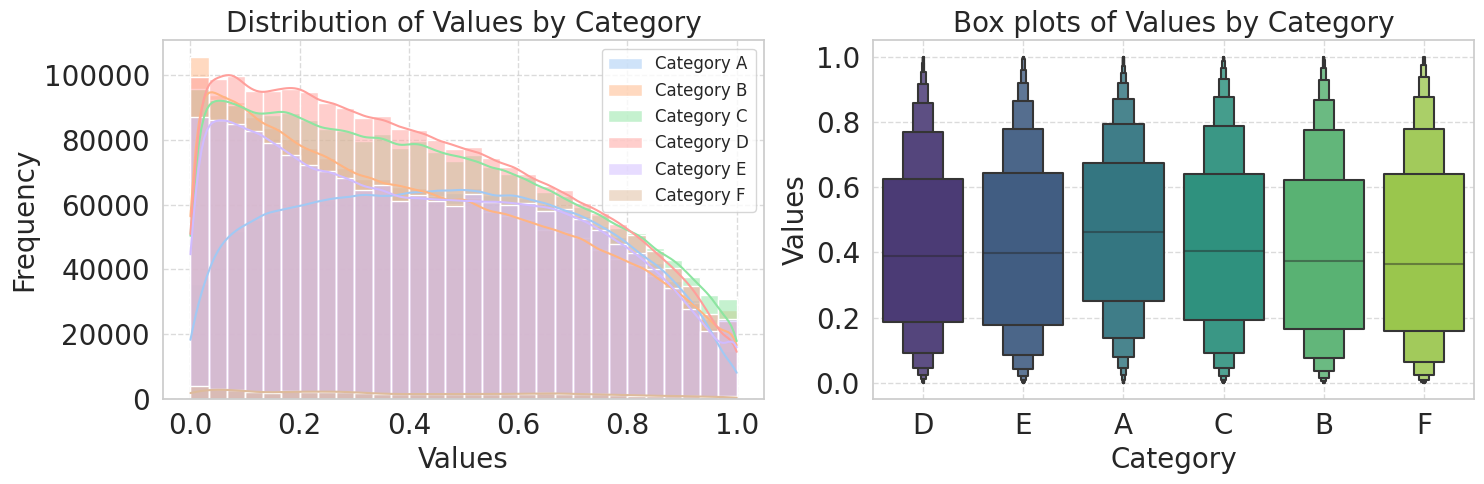

In [92]:
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot - Distribution of values by category
for category in np.unique(dataset['categories']):
    category_data = dataset[dataset['categories'] == category]['values']
    sns.histplot(category_data, bins=30, kde=True, label=f'Category {category}', ax=axs[0], alpha=0.5)
    # Store the distribution for each category
    average_distributions[category] = np.histogram(category_data, bins=30, density=True)[0]
axs[0].set_title('Distribution of Values by Category', fontsize=20)
axs[0].set_xlabel('Values', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)
axs[0].legend(fontsize=12)


# Increase font size for tick labels and set a grid on the first subplot
axs[0].tick_params(axis='both', labelsize=20)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Second subplot - Box plots grouped by Category
sns.boxenplot(x='categories', y='values', data=dataset, ax=axs[1],palette='viridis')
axs[1].set_title('Box plots of Values by Category', fontsize=20)
axs[1].set_xlabel('Category', fontsize=20)
axs[1].set_ylabel('Values', fontsize=20)

# Increase font size for tick labels and set a grid on the second subplot
axs[1].tick_params(axis='both', labelsize=20)
axs[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('distribution_and_boxplot_by_category_viridis.png')
plt.savefig('distribution_and_boxplot_by_category_viridis.pdf')
plt.savefig('distribution_and_boxplot_by_category_viridis.jpeg')

# Show the combined plot
plt.show()

## It seems clear that there is no marked difference betweenthe distribution, so for now we will ignore the category labels

In [29]:
'''
#Visualizing time series F
indexes=np.where(categories=='F')[0]
print(len(indexes))

for i in range (30):
    plt.figure()
    plt.plot(trimmed_data[indexes[i]]) 
'''

"\n\n#Visualizing time series F\nindexes=np.where(categories=='F')[0]\nprint(len(indexes))\n\nfor i in range (30):\n    plt.figure()\n    plt.plot(trimmed_data[indexes[i]])\n    \n"

# Investigating the autocorrelation structure of the data to identify seasonalities


We start by inspecting one plot per category

# Autocorrelation plot analysis

# Autocorrelation measures the correlation of a time series with itself at different delays. Here are the key points:

- **Y-Axis**: Displays the autocorrelation coefficient, ranging from -1 to 1. A value of 1 indicates a perfect positive correlation at that delay, -1 indicates a perfect negative correlation, and 0 indicates no correlation.
- **X-Axis**: Represents the delay, i.e., the number of time periods separating observations in the time series.
- **Blue Bars**: Each bar represents the autocorrelation coefficient for the corresponding delay.
- **Light Blue Area**: Indicates the confidence interval, typically set at 95%. If a bar goes beyond this area, there is generally considered to be significant autocorrelation at that delay.


# Time Series Decomposition Plot

The last plot shows the decomposition of a time series into three main components: trend, seasonality, and residuals.

- **Observed**: The original time series.
- **Trend**: The component showing the long-term trend in the time series. There is a slight variation over time, suggesting a non-constant trend.
- **Seasonal**: The component representing seasonality or patterns that repeat at regular intervals. In this case, it seems to be almost nonexistent, indicating that there are no evident cycles within the time series.
- **Residual**: The component that remains after removing the trend and seasonality. Ideally, residuals should be random noise. In this case, the residuals appear to be very low and constant, suggesting that the decomposition model has captured most of the information.

Decomposition is a useful analysis technique to understand the internal dynamics of a time series and identify which components are predominant. In this case, it is observed that the trend component is present, while seasonality does not seem to be a significant factor. This may influence the type of forecasting model you choose, possibly directing you towards models that can better capture trends rather than those focused on seasonality.

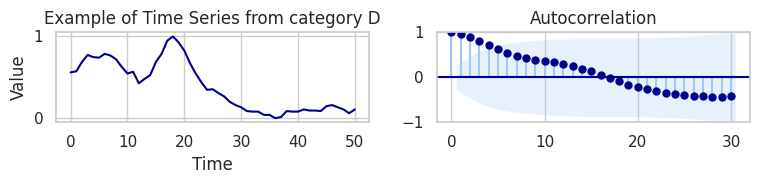

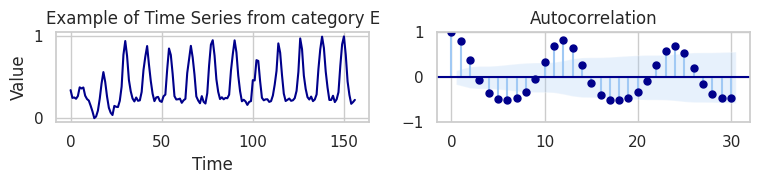

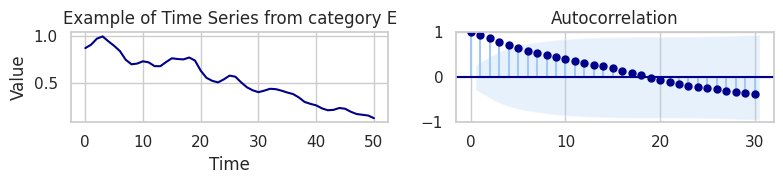

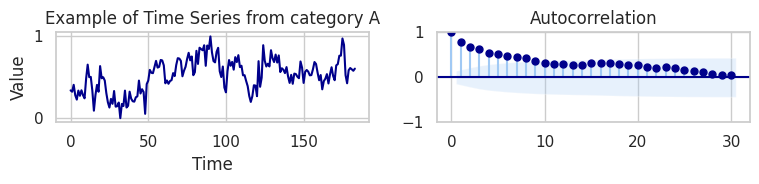

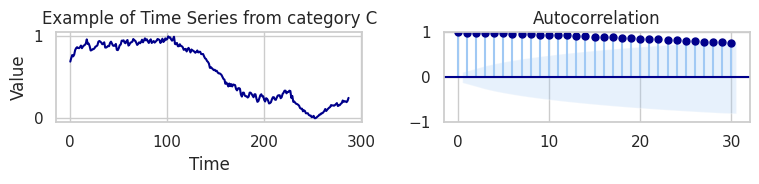

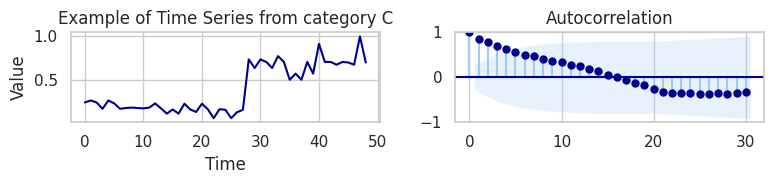

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# Analysis of an individual time series from different categories with autocorrelation
for i in range(10000, 40000, 5000):
    example_series = trimmed_data[i]
    
    # Create a subplot with two axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
    
    # Plot the time series
    ax1.plot(example_series, color='darkblue')
    ax1.set_title(f'Example of Time Series from category {categories[i]}')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')

    # Plot the autocorrelation
    plot_acf(example_series, lags=30, ax=ax2, color='darkblue')
    ax2.set_title('Autocorrelation')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plots
    plt.show()


### It is appearent that there are different autocorrelation prophiles across time series, with some revealing a clear 12-month periodicity. From other plots it also emerges a weekly periodicity. We will take this into consideration not selecting windows that are smaller than 12, to allow to capture well the periodicity

### However, we explore further if there seem to be any class-specific seasonality (by eye)

/tmp/ipykernel_47/3731427307.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,N_cols, figsize=(20,2))


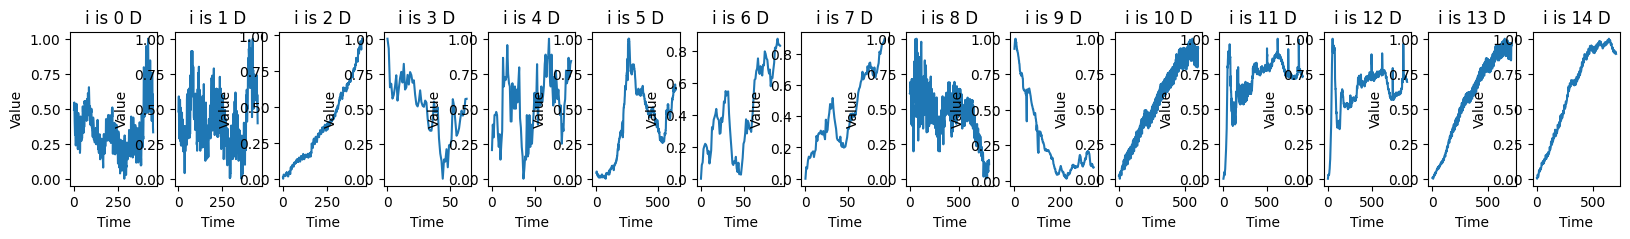

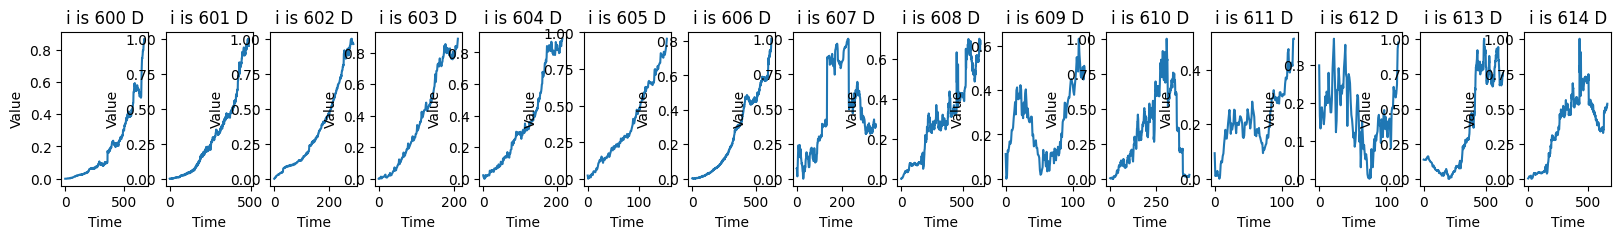

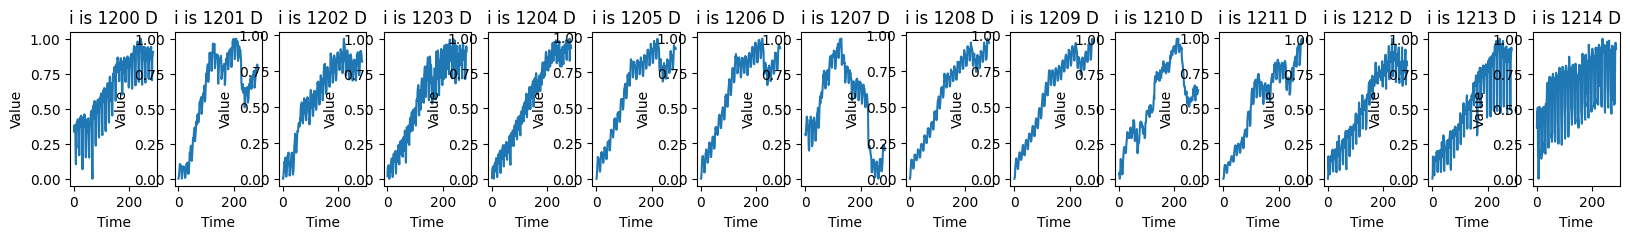

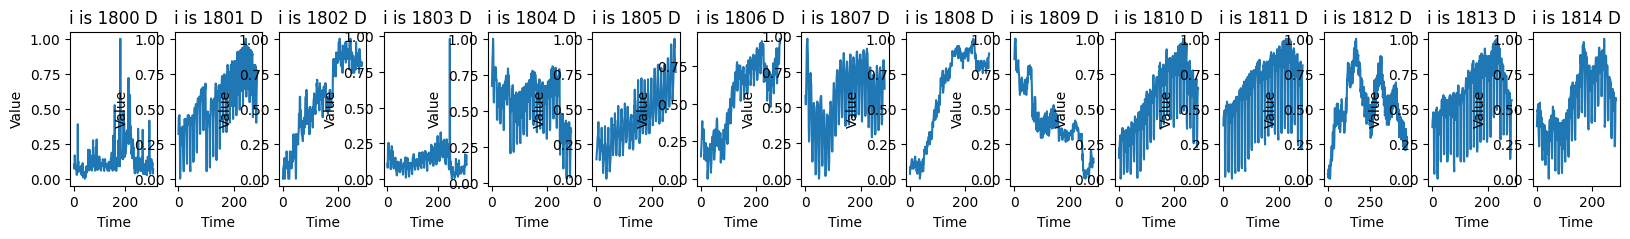

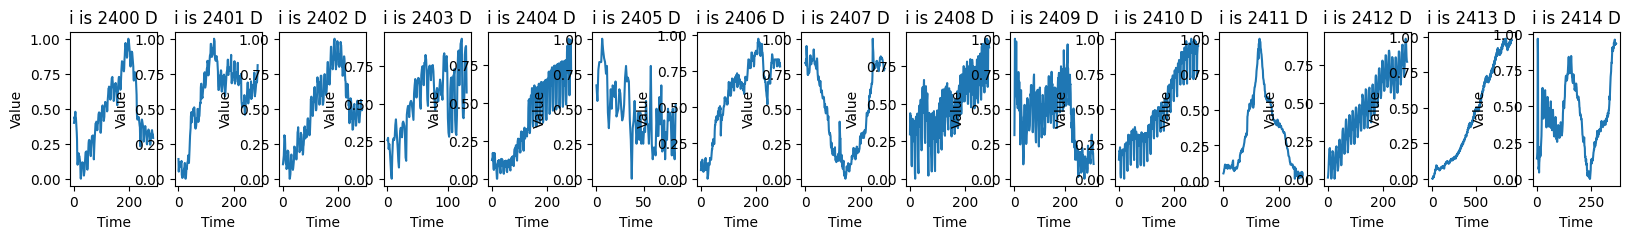

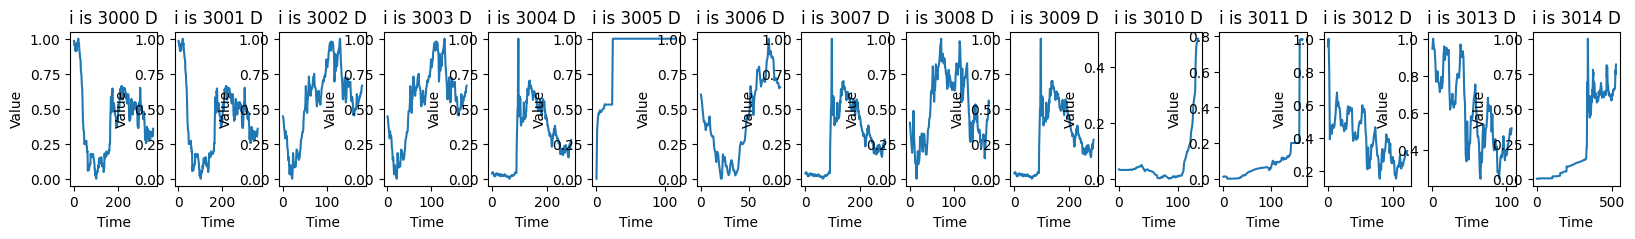

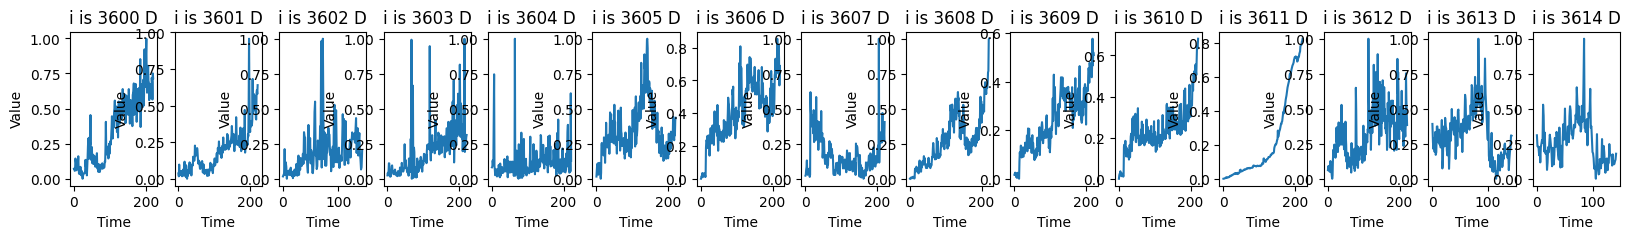

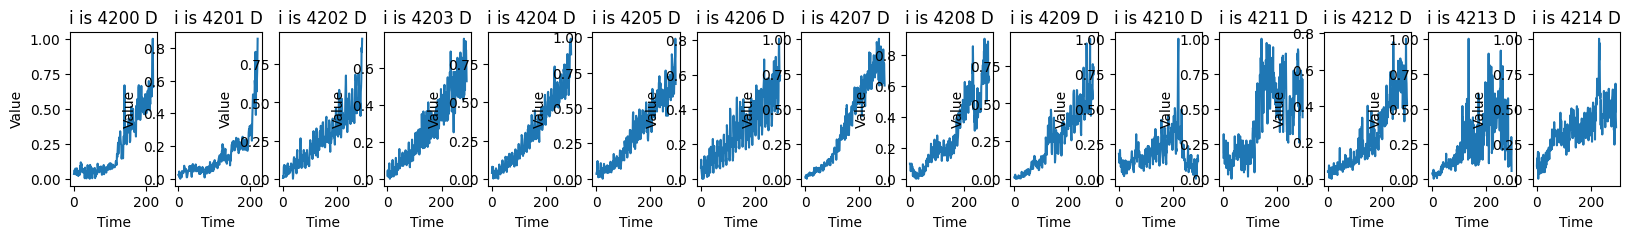

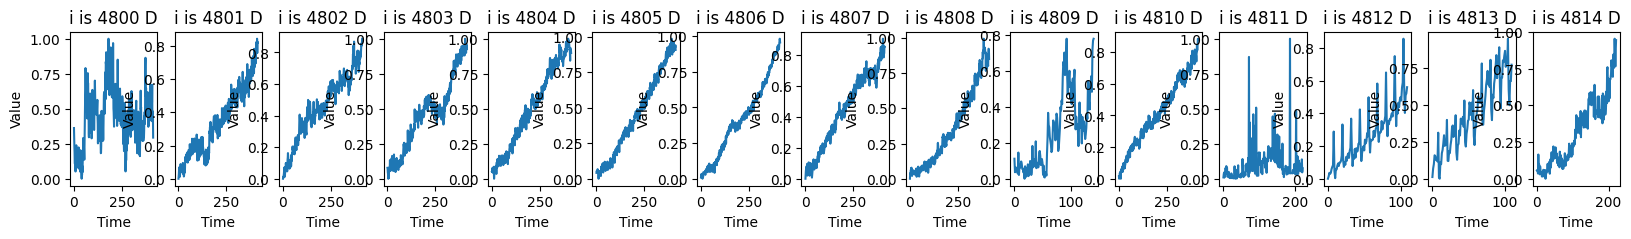

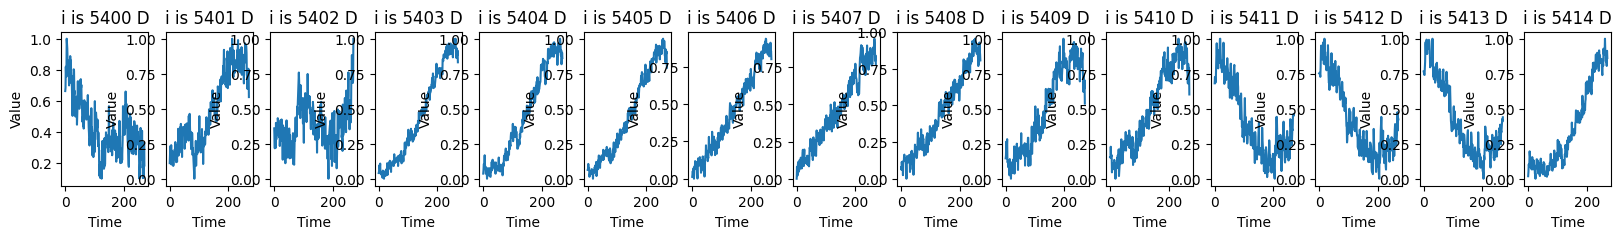

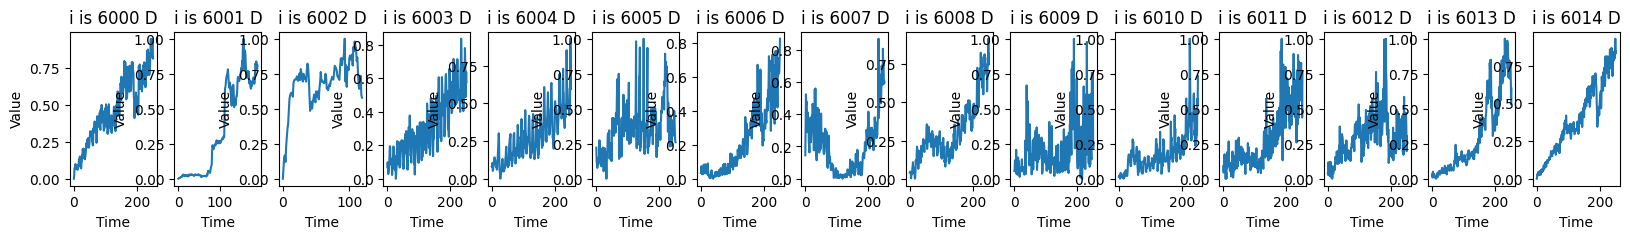

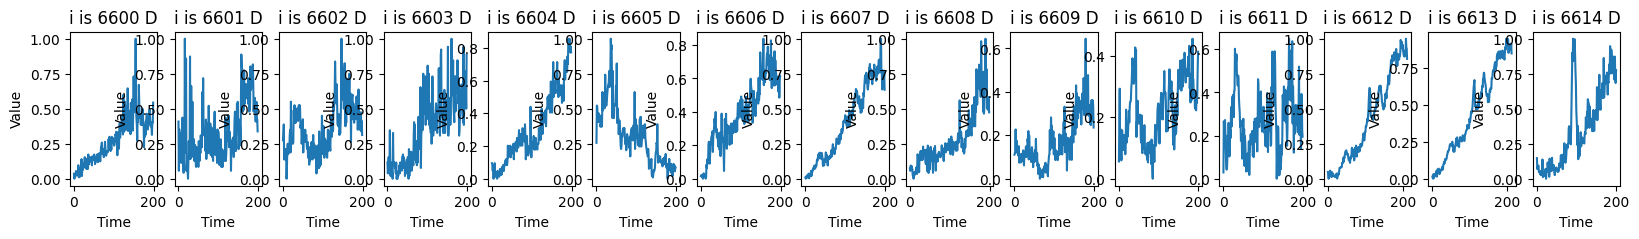

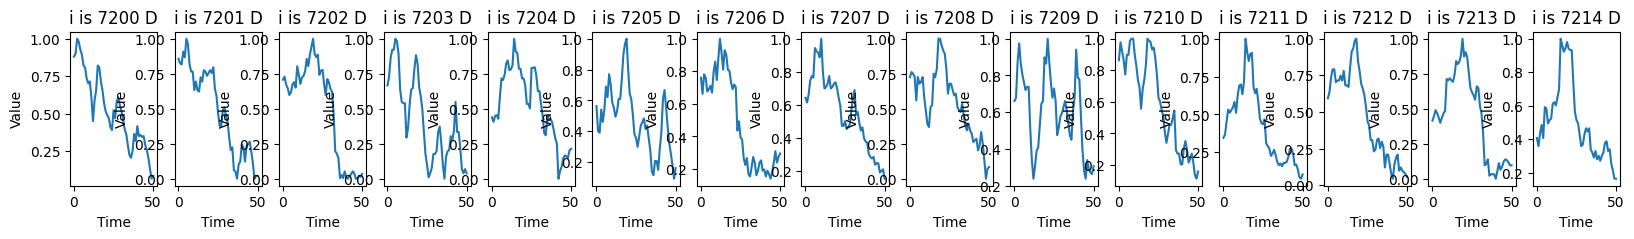

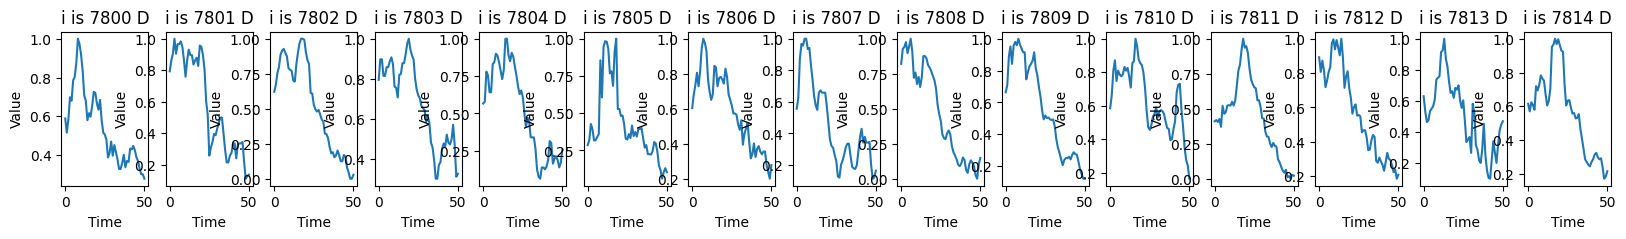

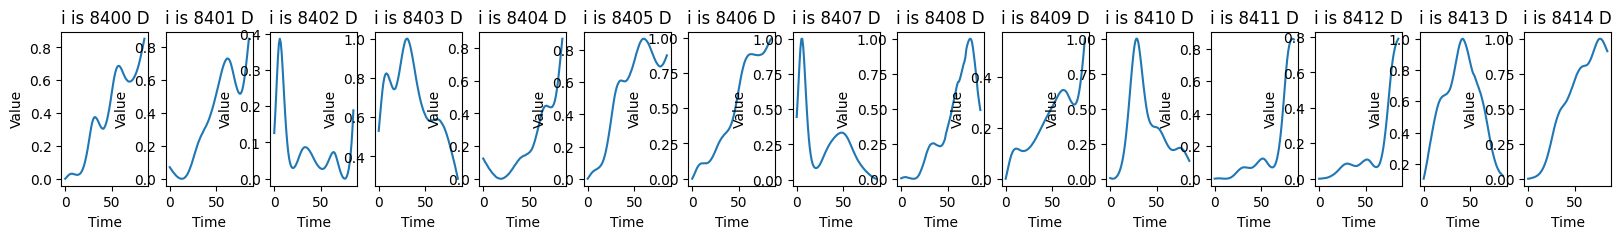

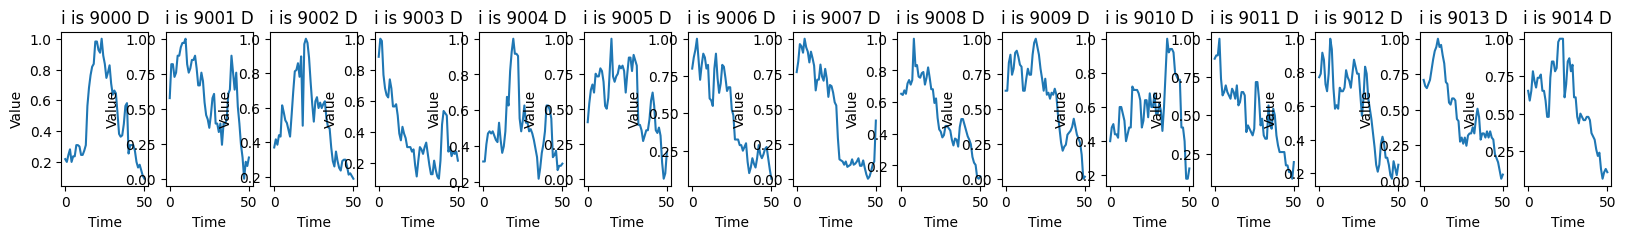

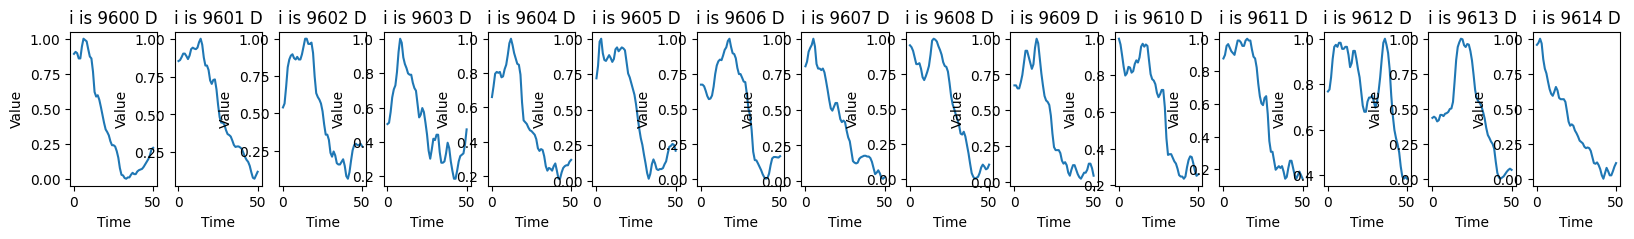

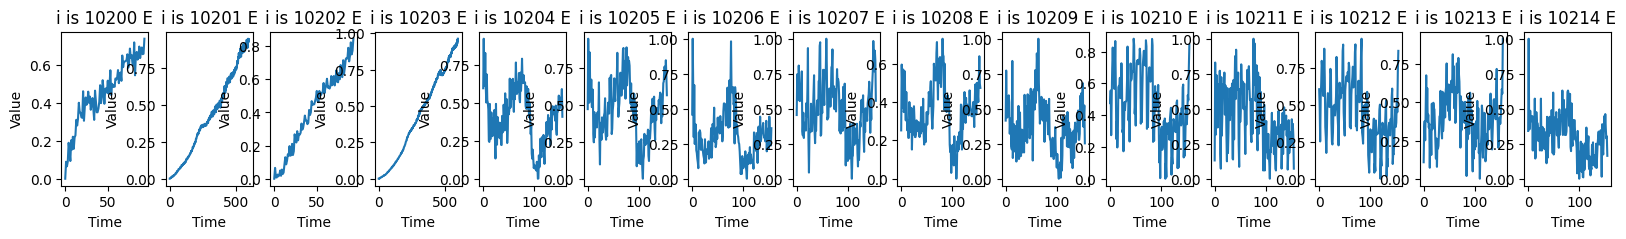

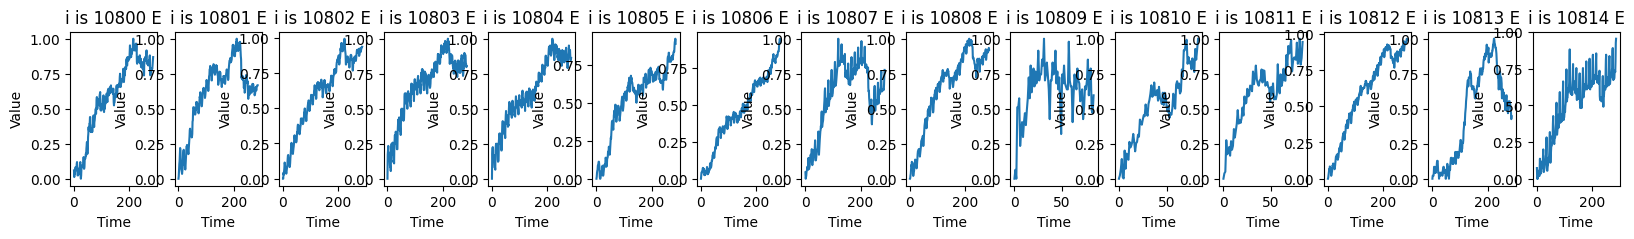

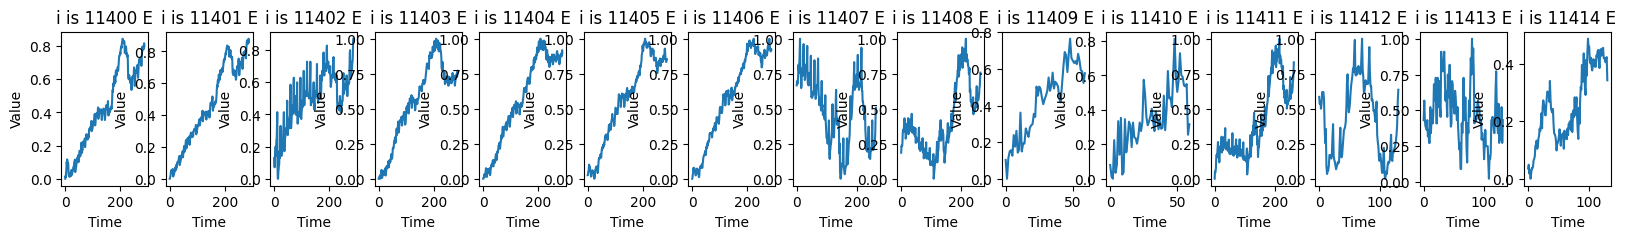

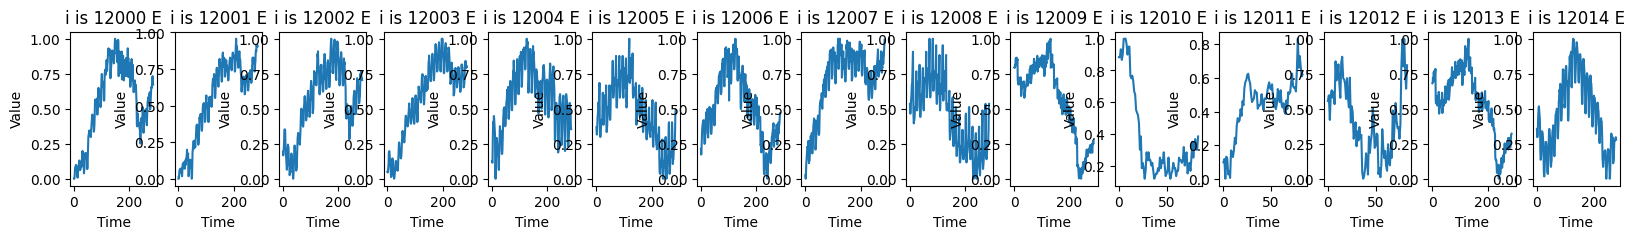

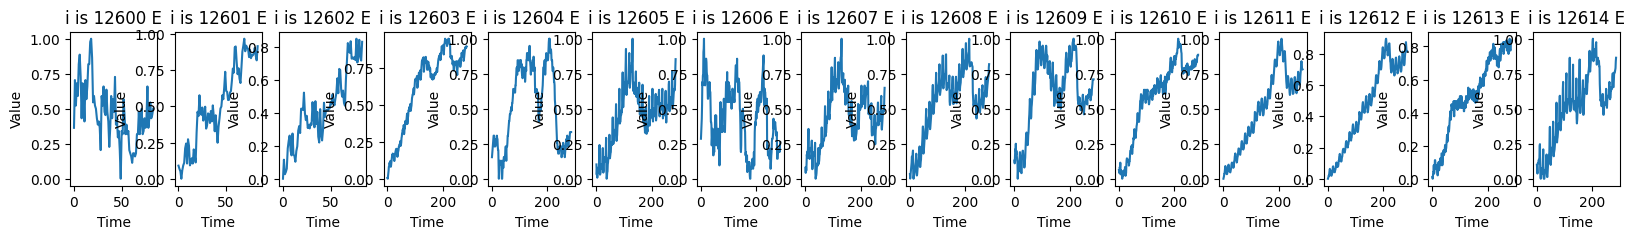

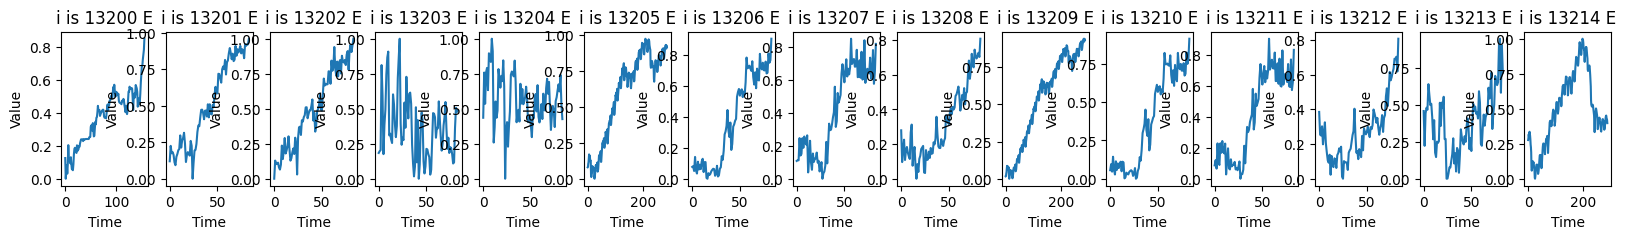

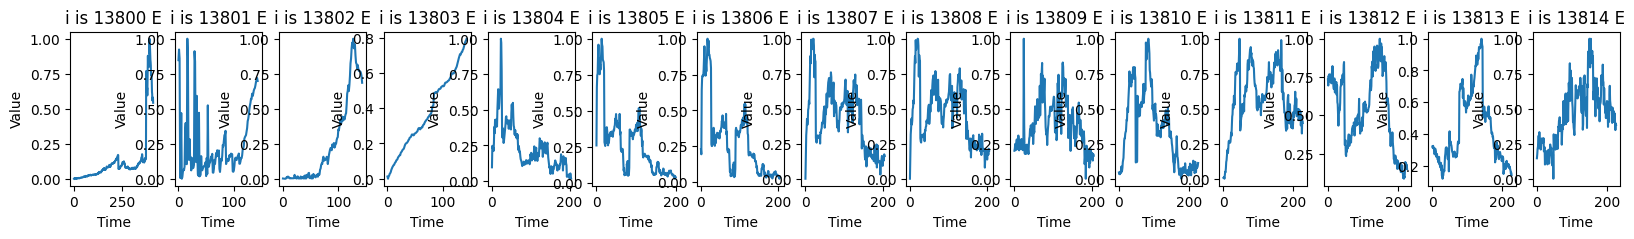

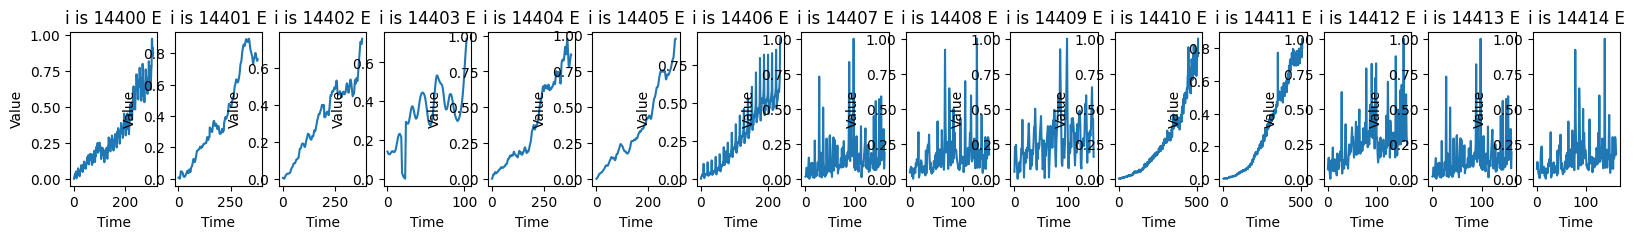

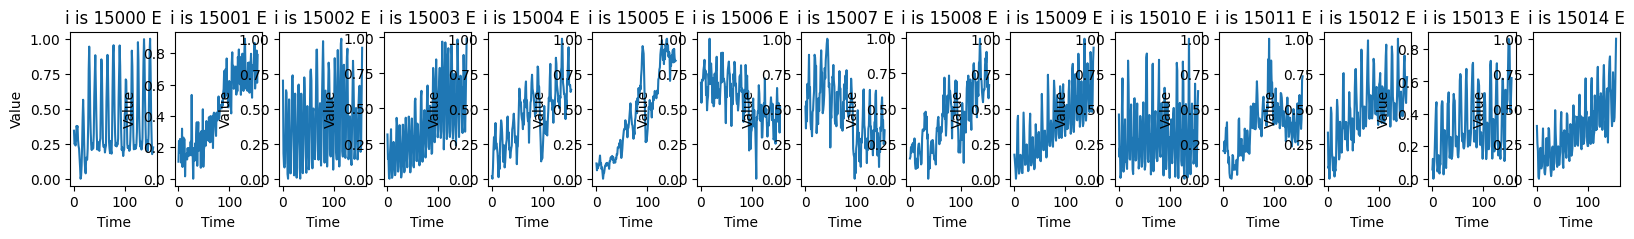

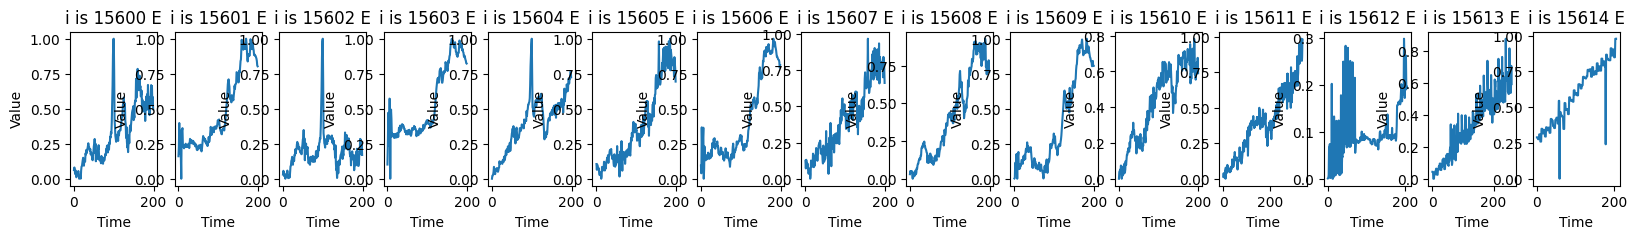

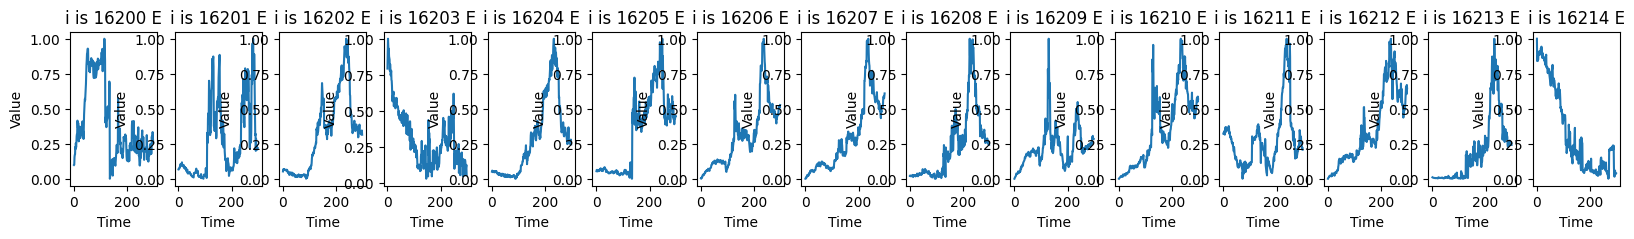

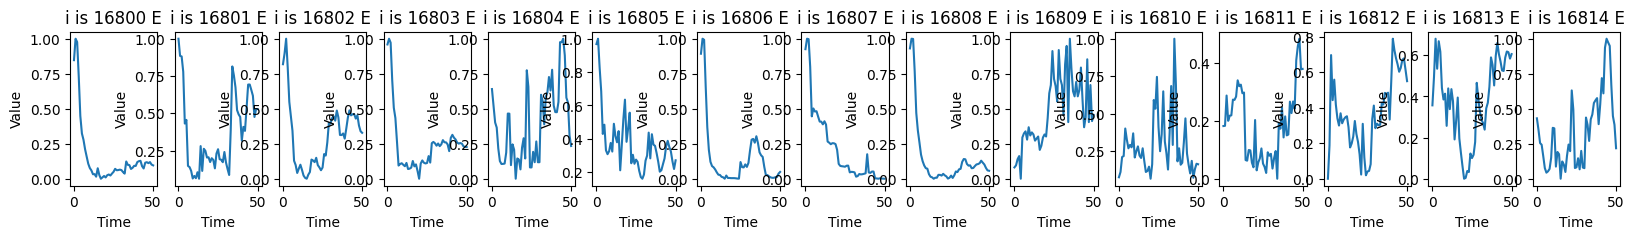

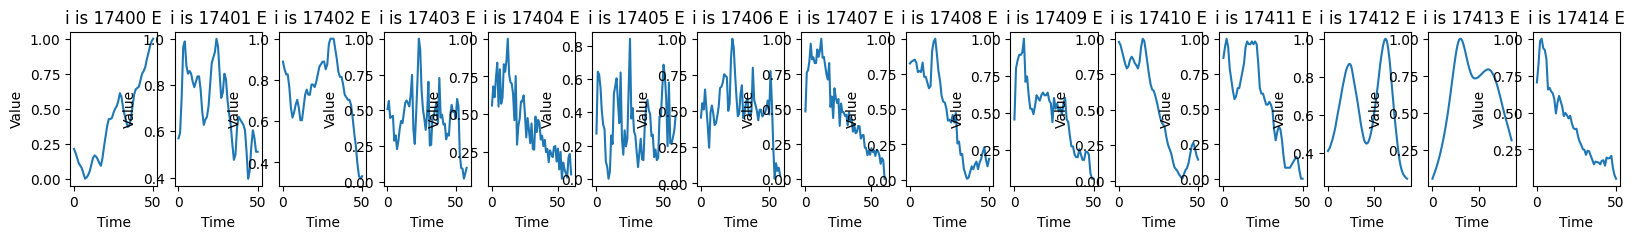

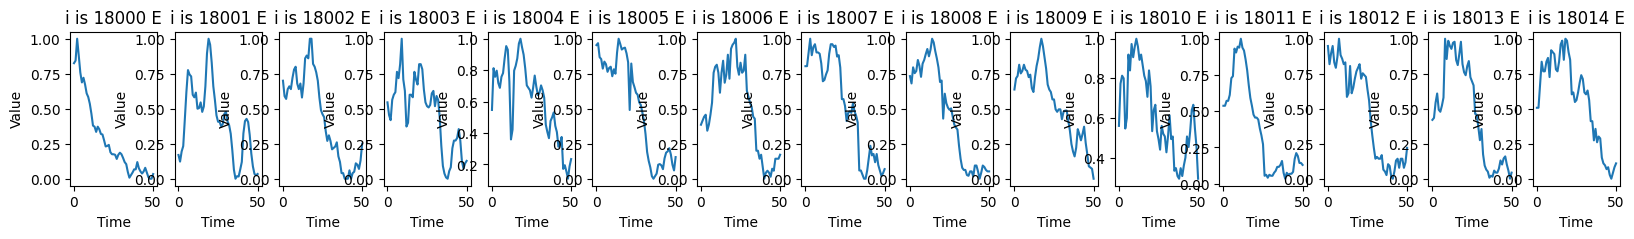

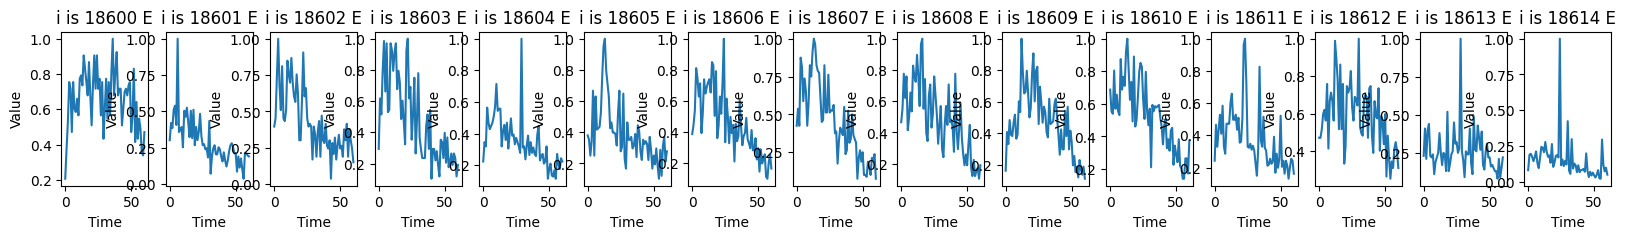

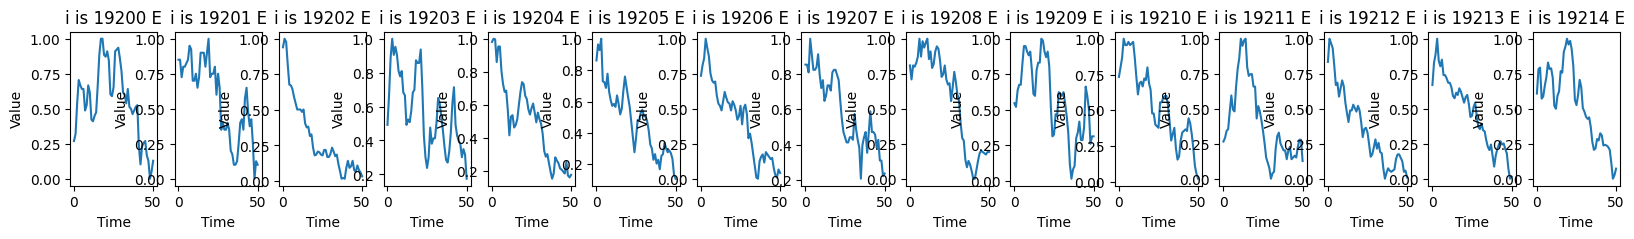

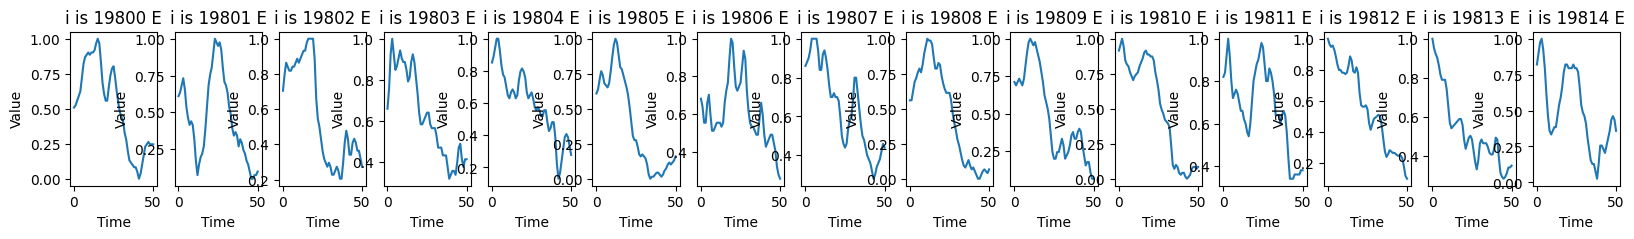

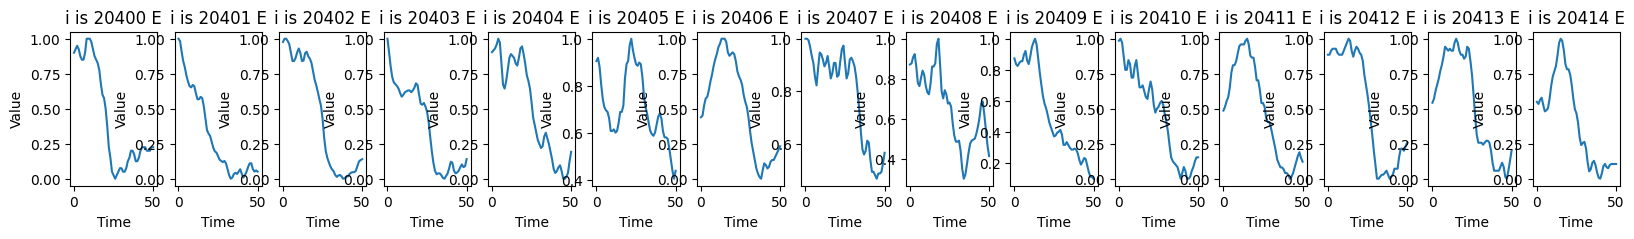

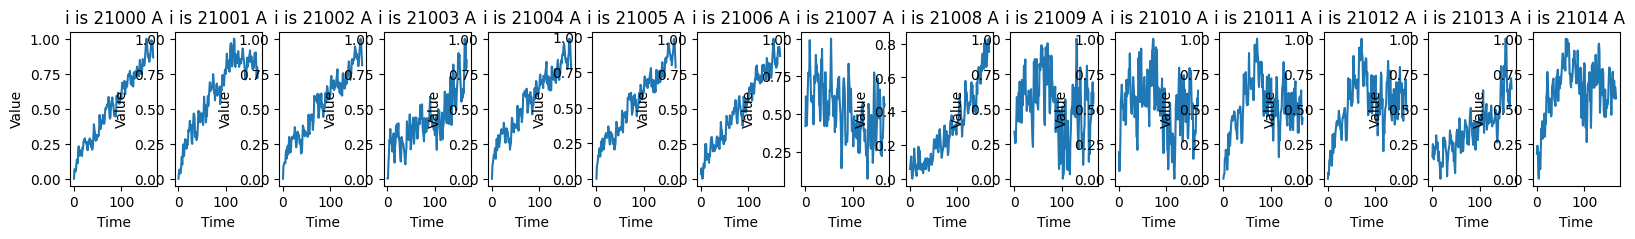

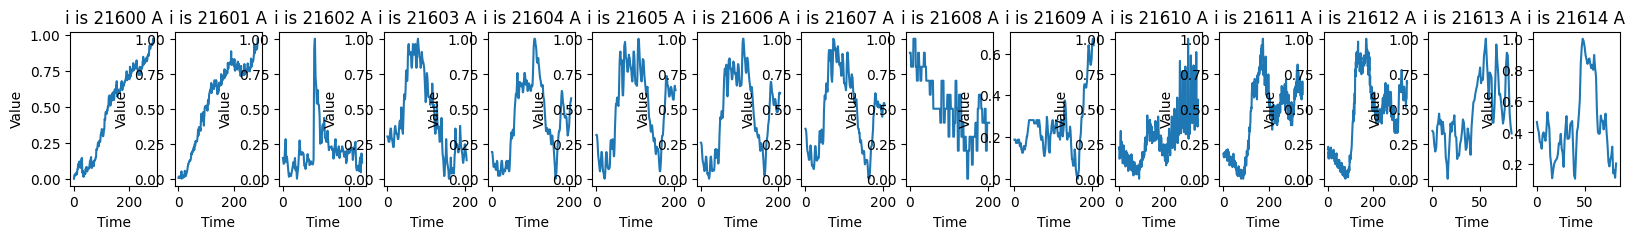

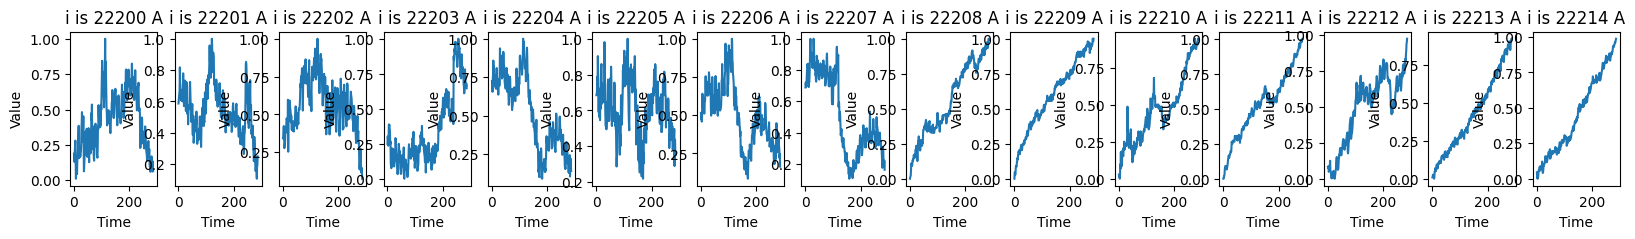

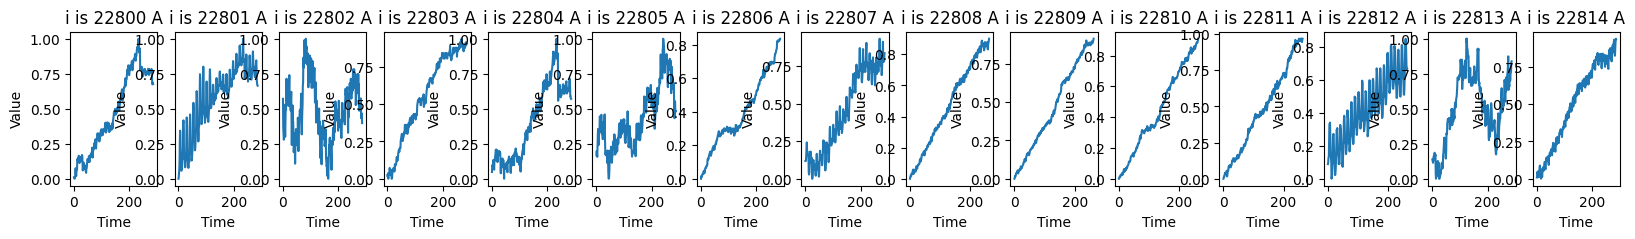

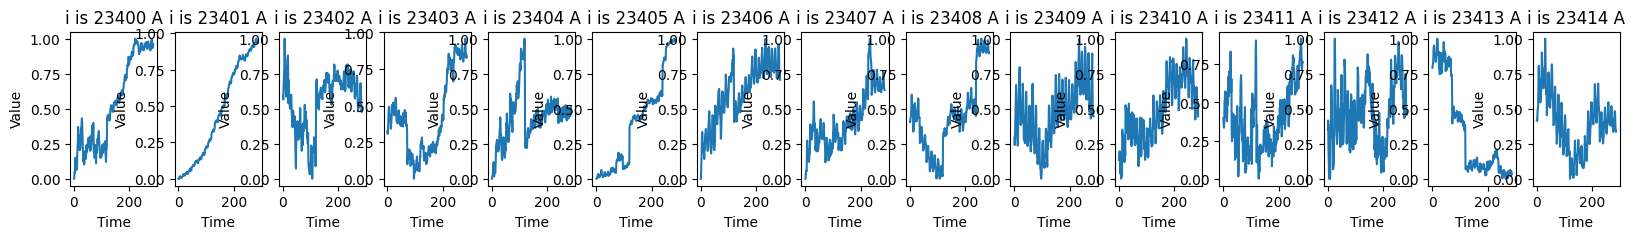

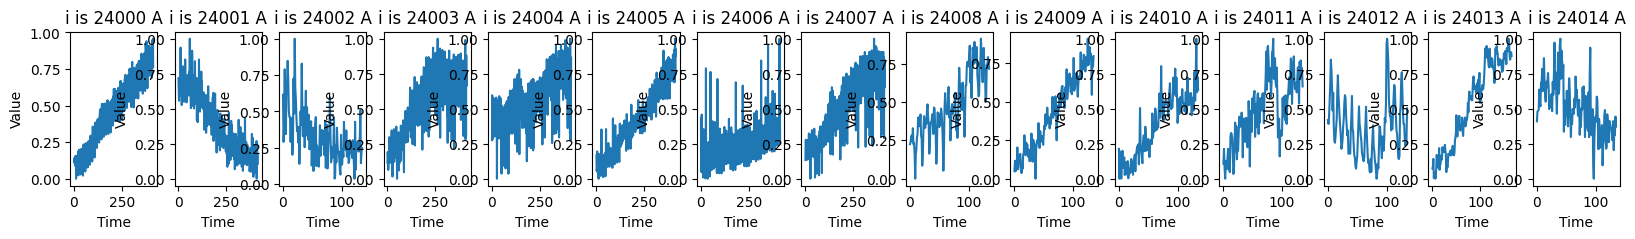

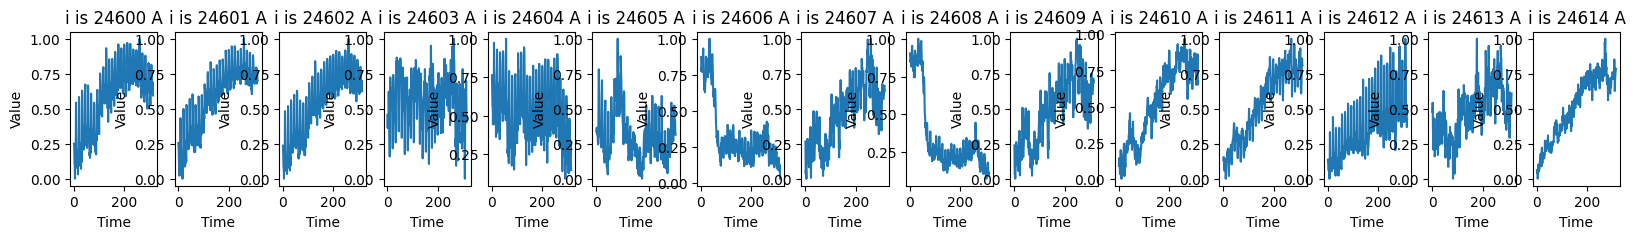

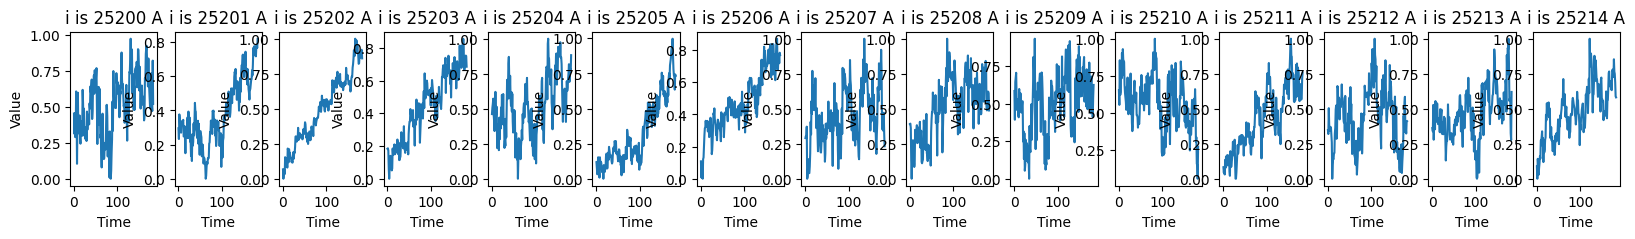

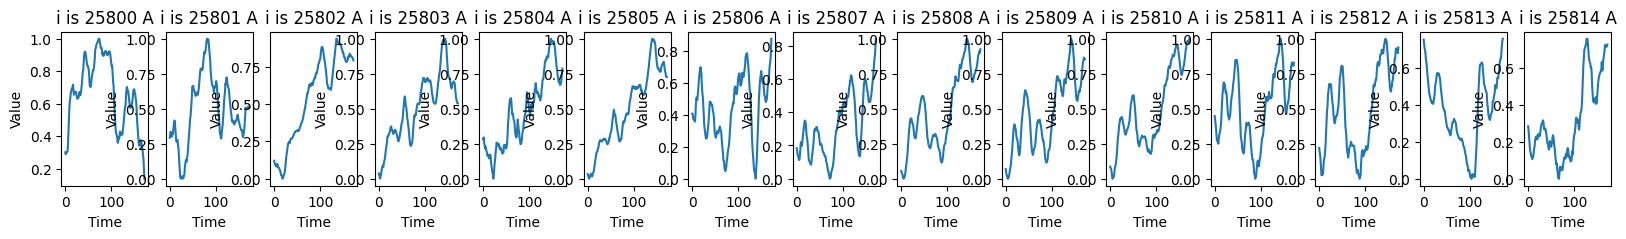

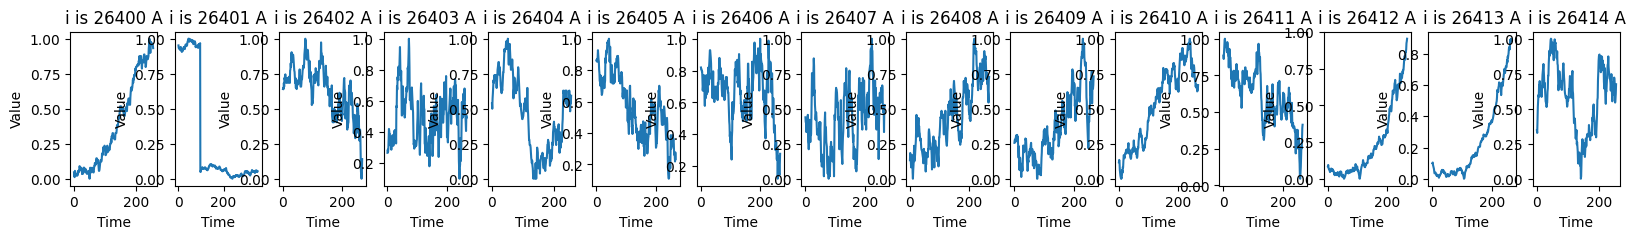

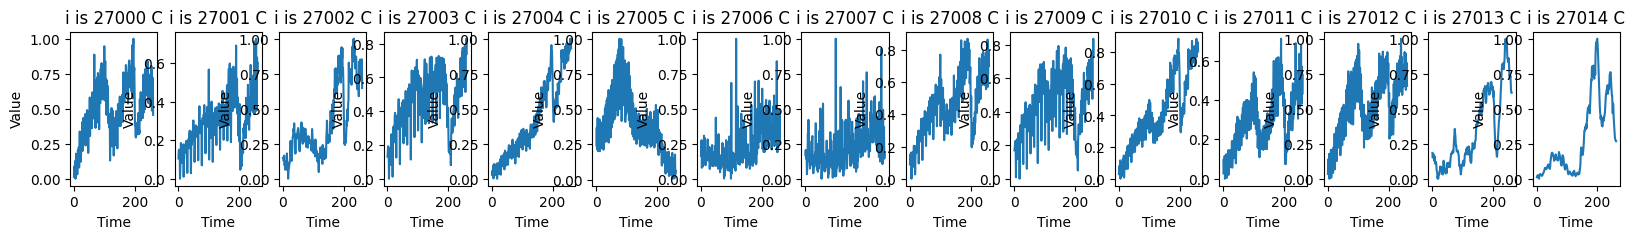

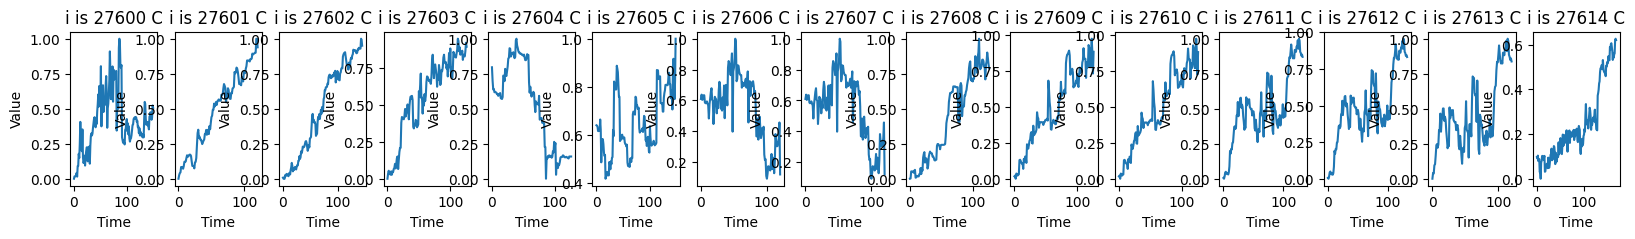

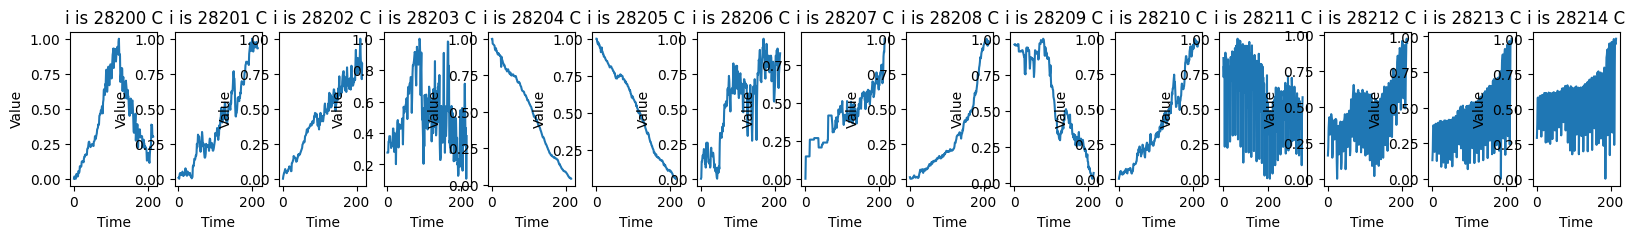

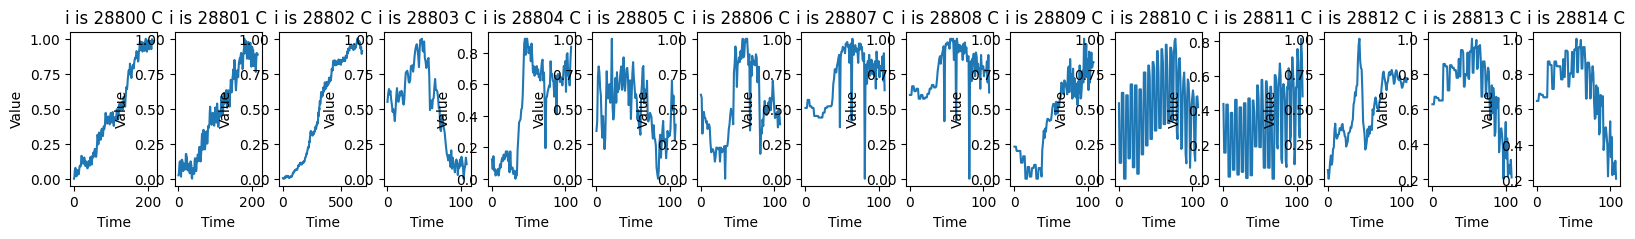

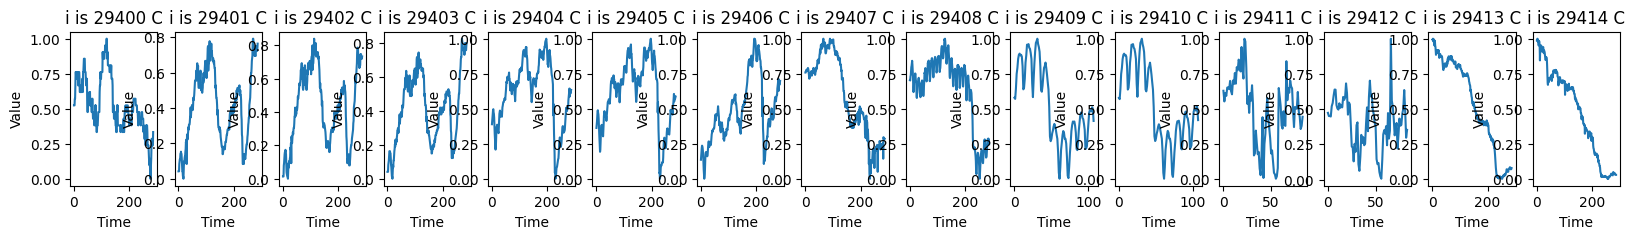

In [86]:
# Define the dimensions of the grid
num_rows = 15
num_cols = 30

# Create a figure and axis for the subplots
N_rows=30000
N_cols=15


for i in range (0, N_rows, int(N_rows/50) ):
    fig, axes = plt.subplots(1,N_cols, figsize=(20,2))
    for j in range(N_cols):
        index=i+j
        axes[j].plot(trimmed_data[index])
        axes[j].set_title(f'i is {index} {categories[index]}')
        axes[j].set_xlabel('Time')
        axes[j].set_ylabel('Value')

## We study the acf and pacs every 7 and 12 timesteps ,

In [15]:
from statsmodels.tsa.stattools import pacf, acf

# Create a subset of time series longer than or equal to the threshold
subset_data = [ts for ts in trimmed_data if len(ts) >= 72]

# Create arrays to store lag-specific values for each time series
lag_7_pacf = np.zeros(len(subset_data))
lag_12_pacf = np.zeros(len(subset_data))
lag_7_acf = np.zeros(len(subset_data))
lag_12_acf = np.zeros(len(subset_data))

normalized_lag_7_pacf = np.zeros(len(subset_data))
normalized_lag_12_pacf = np.zeros(len(subset_data))
normalized_lag_7_acf = np.zeros(len(subset_data))
normalized_lag_12_acf = np.zeros(len(subset_data))

# Iterate over each time series
for idx, time_series in enumerate(subset_data):
    # Calculate PACF and ACF once
    pacf_values = pacf(time_series, nlags=12)[0:12]  
    acf_values = acf(time_series, nlags=12)[0:12]

    # Extract lag-specific values
    lag_7_pacf[idx] = pacf_values[6]
    lag_12_pacf[idx] = pacf_values[11]
    
    lag_7_acf[idx] = acf_values[6]
    lag_12_acf[idx] = acf_values[11]

    # Calculate averages for normalization
    avg_over_7_pacf = np.mean(pacf_values[1:8]) # Exclude the 0 lag
    avg_over_12_pacf = np.mean(pacf_values[1:13]) # Exclude the 0 lag

    avg_over_7_acf = np.mean(acf_values[1:8]) # Exclude the 0 lag
    avg_over_12_acf = np.mean(acf_values[1:13]) # Exclude the 0 lag

    # Normalize values
    normalized_lag_7_pacf[idx] = avg_over_7_pacf#lag_7_pacf[idx] / avg_over_7_pacf
    normalized_lag_12_pacf[idx] = avg_over_12_pacf#lag_12_pacf[idx] / avg_over_12_pacf

    normalized_lag_7_acf[idx] = avg_over_7_acf#lag_7_acf[idx] / avg_over_7_acf
    normalized_lag_12_acf[idx] =avg_over_12_acf # lag_12_acf[idx] / avg_over_12_acf

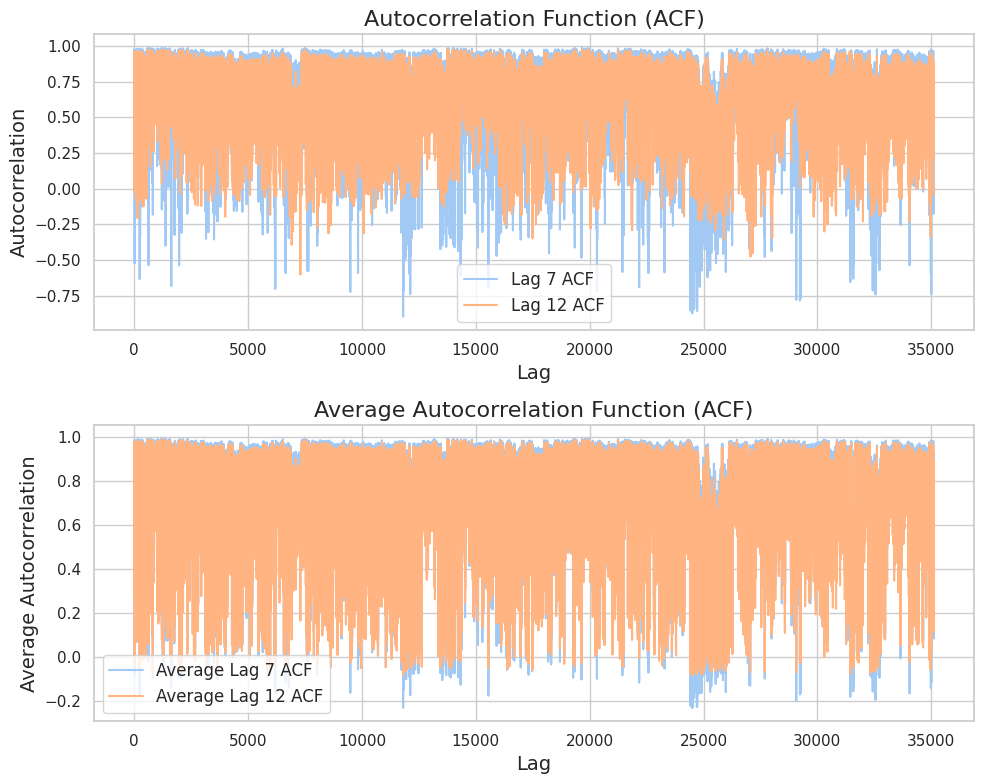

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set a seaborn style for improved aesthetics
sns.set(style="whitegrid", palette="pastel")

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - ACF without normalization
axs[0].plot(lag_7_acf, label='Lag 7 ACF')
axs[0].plot(lag_12_acf, label='Lag 12 ACF')
axs[0].set_title('Autocorrelation Function (ACF)', fontsize=16)
axs[0].set_xlabel('Lag', fontsize=14)
axs[0].set_ylabel('Autocorrelation', fontsize=14)
axs[0].legend(fontsize=12)

# Second subplot - Normalized ACF
axs[1].plot(normalized_lag_7_acf, label='Average Lag 7 ACF')
axs[1].plot(normalized_lag_12_acf, label='Average Lag 12 ACF')
axs[1].set_title('Average Autocorrelation Function (ACF)', fontsize=16)
axs[1].set_xlabel('Lag', fontsize=14)
axs[1].set_ylabel('Average Autocorrelation', fontsize=14)
axs[1].legend(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

['Periodic_12']


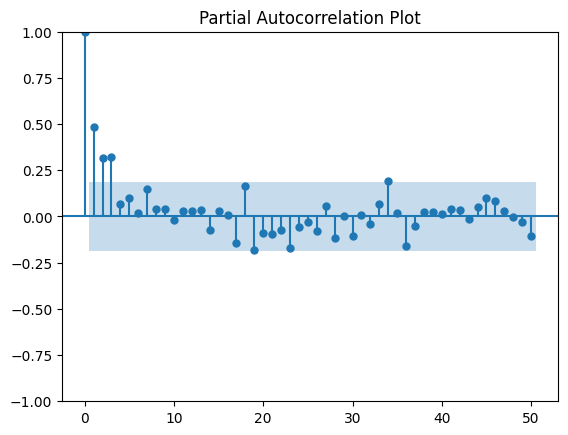

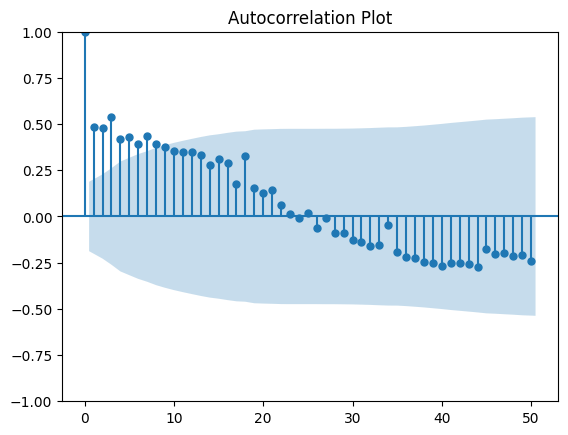

46
0


In [197]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

index= 28808 #28211#28811
print(results_array[index])
example_series = trimmed_data[index]

# Generate some example time series data
# Compute partial autocorrelation coefficients
lags = 50  # Set the number of lags to consider
pacf_values = pacf(example_series, nlags=lags)
acf_values = acf(example_series, nlags=lags)

# Plot the partial autocorrelation plot
plot_pacf(example_series, lags=lags, title='Partial Autocorrelation Plot')
plt.show()
# Plot the partial autocorrelation plot
plot_acf(example_series, lags=lags, title='Autocorrelation Plot')
plt.show()

print(np.where(pacf_values==np.max(pacf_values))[0][0])
print(np.where(acf_values==np.max(acf_values))[0][0])

## Other visualizations

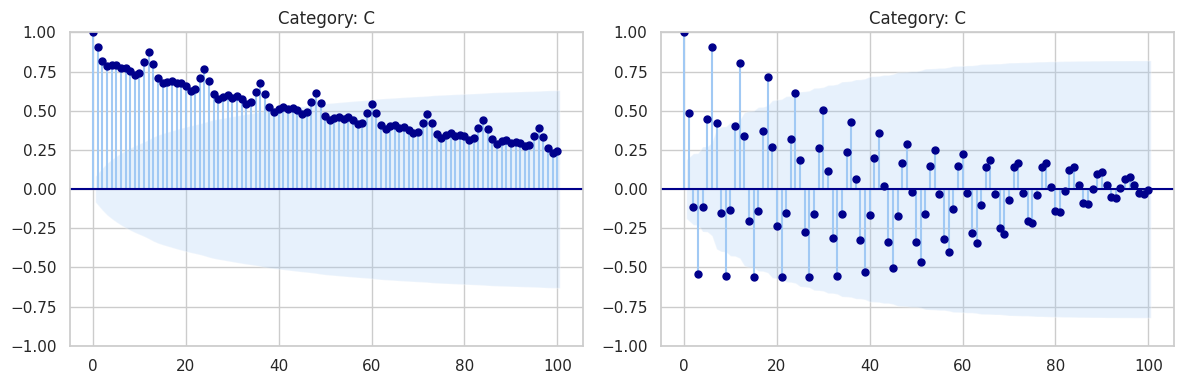

In [60]:
# Set up a figure with two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Autocorrelation for the first series
example_series_1 = trimmed_data[26813]
plot_acf(example_series_1, lags=100, color='darkblue', ax=axes[0])
axes[0].set_title(f'Category: {categories[26813]}')

# Autocorrelation for the second series
example_series_2 = trimmed_data[28810]
plot_acf(example_series_2, lags=100, color='darkblue', ax=axes[1])
axes[1].set_title(f'Category: {categories[28810]}')

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('autocorrelation.jpeg')
plt.savefig('autocorrelation.pdf')

plt.show()

### Based on these considerations, we decided to always use windows greater than 12 to allow to accomodate for the seasonal trends.

Category A: Average length = 278.18034217877096, Standard deviation = 109.29037955112395


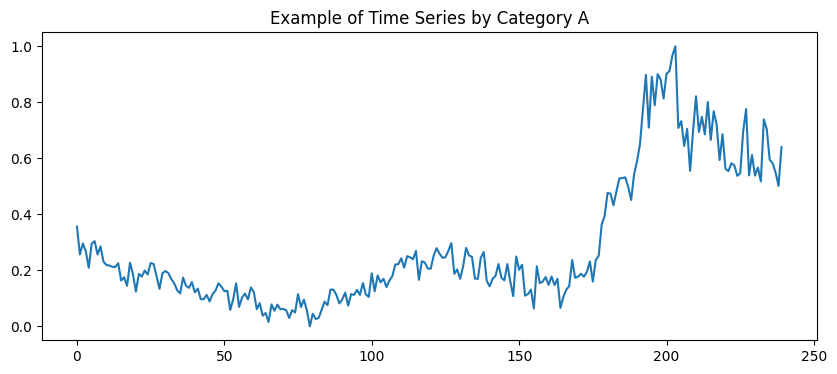

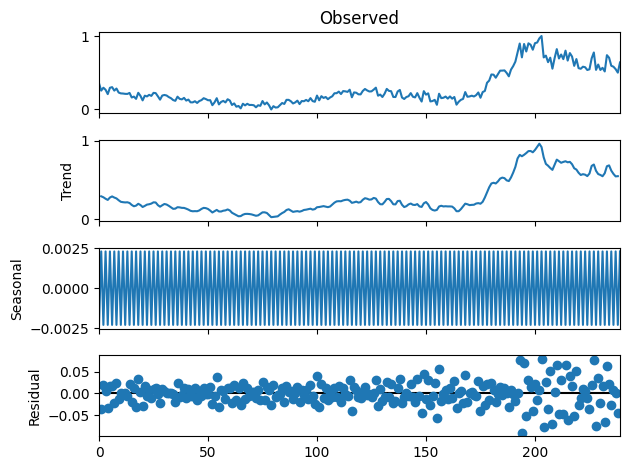

Category B: Average length = 165.9428415400018, Standard deviation = 116.14192781719757


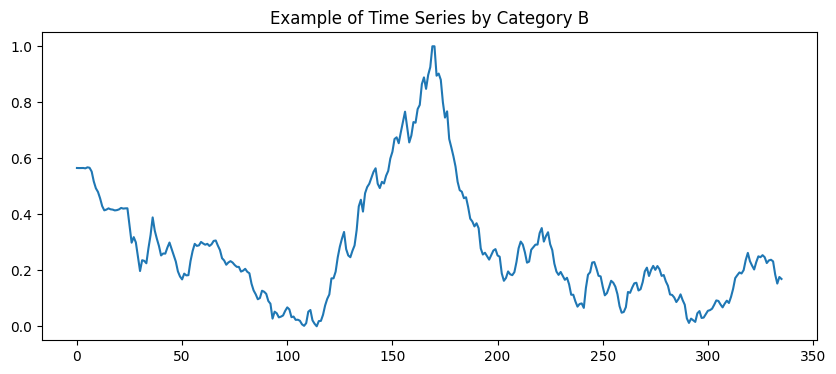

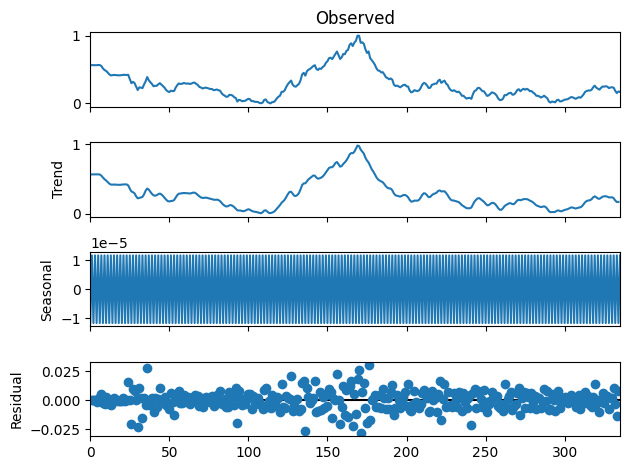

Category C: Average length = 208.14625137266646, Standard deviation = 146.2894169943084


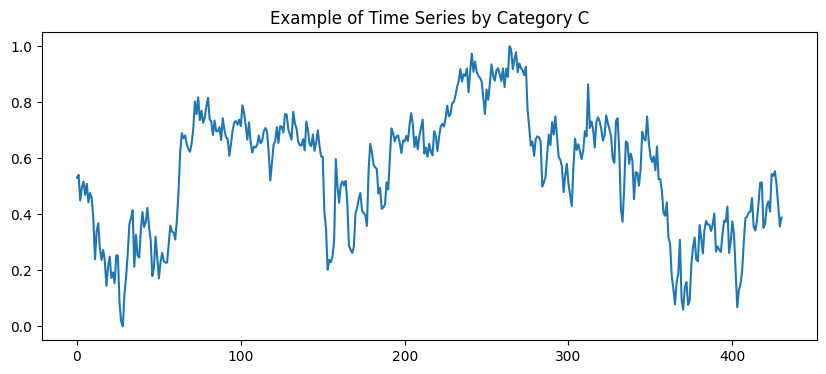

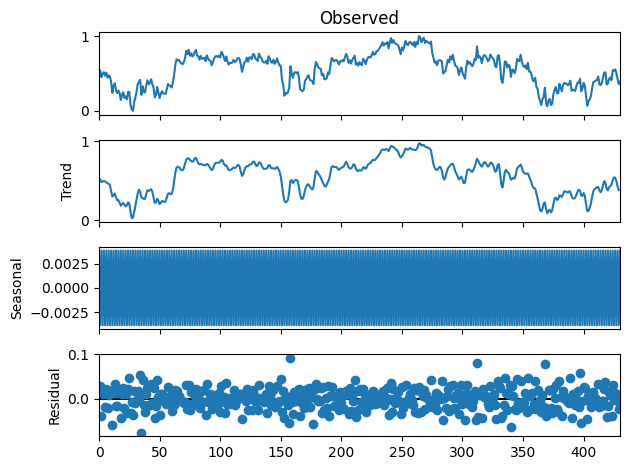

Category D: Average length = 216.9909145367412, Standard deviation = 149.1739525357881


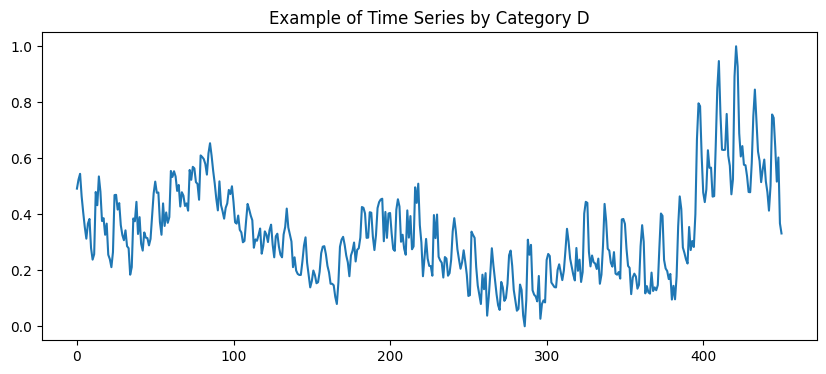

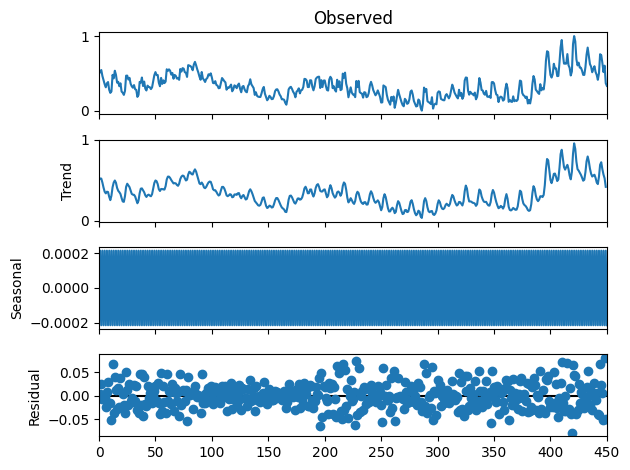

Category E: Average length = 163.04601366742597, Standard deviation = 127.99233668736717


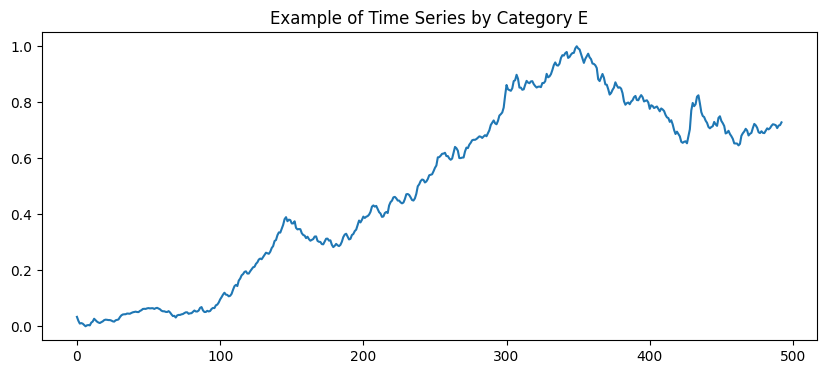

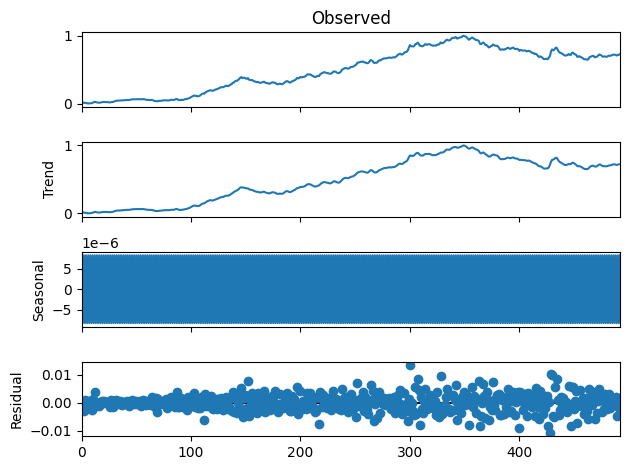

Category F: Average length = 194.8303249097473, Standard deviation = 153.41084633336763


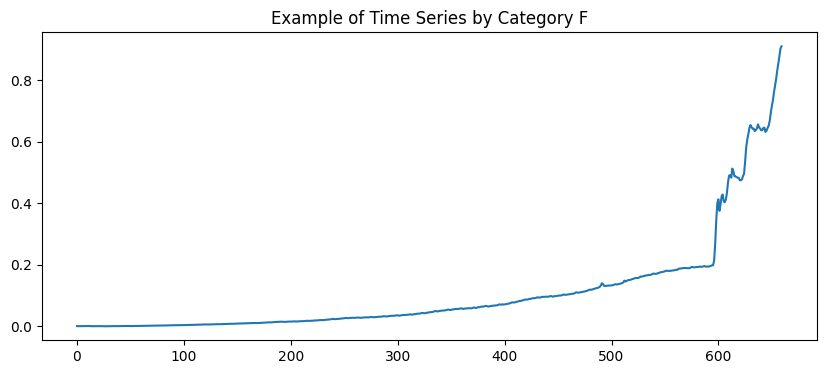

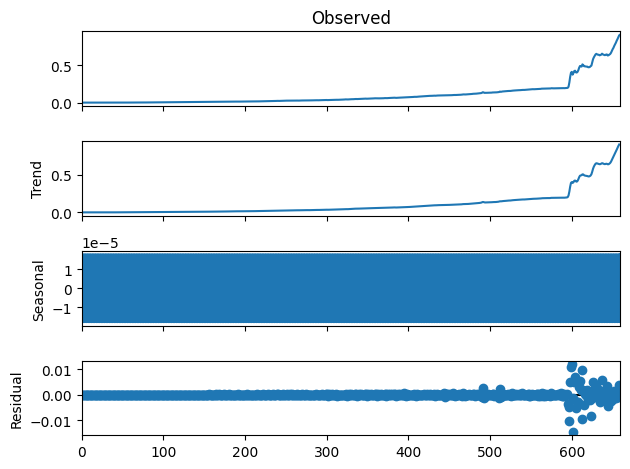

In [34]:

# Convertire in DataFrame per analisi facilitata
df = pd.DataFrame({
    'Series': trimmed_data,
    'Category': categories
})

indexes=[]

# Analisi per Categoria
category_groups = df.groupby('Category')
for name, group in category_groups:
    
    lengths = group['Series'].apply(len)
    print(f"Category {name}: Average length = {lengths.mean()}, Standard deviation = {lengths.std()}")

    # Visualizzazione di una serie temporale per categoria
    example_series = group['Series'].iloc[0]
    
    plt.figure(figsize=(10, 4))
    plt.plot(example_series)
    plt.title(f'Example of Time Series by Category {name}')
    plt.show()


    # Analisi di Tendenza e Stagionalità (su una serie temporale esemplificativa)
    result = seasonal_decompose(example_series, model='additive', period=min(2, len(example_series)//2)) # Impostare il periodo appropriato!!! (da controllare)
    result.plot()
    plt.show()